# Stock Portfolio Forecasting and Optimization on S&P500 Using Machine Learning and Search Methods

-----------------------------------------------------------------------

Alexandre Sousa - up202206427 

Magda Costa - up202207036

Marta Longo - up202207985

Sara Táboas - up202205101 

-----------------------------------------------------------------------

# Índice  <a name = "indice"></a>
1. [Introdução](#int)
2. [Pré-Processamento dos Dados](#ppd)

      - [Companies](#ppd_comp)
      - [Dataset](#ppd_data)
3. [Criação de Features Temporais](#temp)
4. [Organização dos Dados](#od)
5. [Random Forest](#rf)
    - [Treino do Modelo - RF](#tm_rf)
    - [Criação e otimização do portfolio - RF](#p_rf)
6. [LSTM](#lstm)
    - [Treino do Modelo - LSTM](#tm_lstm)
    - [Criação e otimização do portfolio - LSTM](#p_lstm)
7. [Comparação de Resultados](#cr)
    - [Criação do portfolio real](#p_cr)
    - [Discussão de Resultados](#dr_cr)
8. [Conclusão](#conclusao)
9. [Referências](#ref)

----

# Introdução <a name = "int"></a>
[[voltar ao índice]](#indice)

Este projeto explora a utilização de técnicas de machine learning e métodos de otimização para a previsão de preços de ações e criação de portfólios eficientes no contexto do índice S&P 500. Dado o caráter volátil e imprevisível do mercado financeiro, o objetivo é desenvolver modelos que combinem previsões precisas com estratégias de otimização robustas, como simulações de Monte Carlo. O foco está em maximizar os retornos ou minimizar os riscos, oferecendo uma abordagem prática e fundamentada para desafios reais de investimento. Ao utilizar dados históricos de 2010 a 2023 e simular cenários para janeiro de 2024, pretende-se avaliar a aplicabilidade e impacto das soluções propostas no mercado financeiro.

Bibliotecas necessárias: 


In [1]:
import pandas as pd
import holidays
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm.notebook import tqdm
from numpy.random import dirichlet
from joblib import dump
from lstm import *

# Pré-Processamento dos Dados <a name = "ppd"></a>
[[voltar ao índice]](#indice)

O pré-processamento dos dados é uma das etapas mais importantes no desenvolvimento de modelos de previsão e otimização. Nesta fase, o objetivo é limpar, transformar e organizar os dados de forma a prepará-los para análise e modelagem eficaz.

Começamos, portanto, por fazer a leitura dos dados. No nosso caso os dados foram obtidos atravez do ficheiro python 'obter_dados.py' que nos permitiu aceder aos dados do **Yahoo Finance** e guardá-los num csv. Nesse ficheiro de código descarregamos todos os dados disponiveis relativamente às empresas que compõe o S&P500 no periodo de tempo entre **1 de janeiro de 2010** e **31 de janeiro de 2024**.

De modo a identificar as empresas que compõe o S&P500 utilizamos o dataset 'sp500_companies.csv' que se encontra disponivel no seguinte link [[KAGGLE]](#KAGGLE), juntamente com outros datasets do S&P500 que puderiamos utilizar para este projeto, contudo, após analisar esses dados percebemos que havia muitos valores em falta, pelo que optamos por utilizar apenas a lista das empresas para obter os dados necessários.

## Companies <a name = "ppd_comp"></a>
[[voltar ao Pré-Processamento dos Dados]](#ppd)

Tal como mencionado previamente, este dataset contém uma lista das empresas que compõe o S&P500, mas, para além disso contém também alguns dados relativos a essas empresas.

In [2]:
df_companies = pd.read_csv("sp500_companies.csv")

In [3]:
df_companies.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,145.26,3563227709440,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.063544
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,224.23,3389415751680,1.346610e+11,0.061,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.060445
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,418.01,3107854221312,1.365520e+11,0.160,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.055424
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,181.97,2217249865728,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.039541
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,180.35,2216122646528,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.039521


In [4]:
df_companies.tail()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
498,NYQ,HII,"Huntington Ingalls Industries,","Huntington Ingalls Industries, Inc.",Industrials,Aerospace & Defense,206.63,8085287424,1.071000e+09,-0.024,Newport News,VA,United States,44000.0,"Huntington Ingalls Industries, Inc. designs, b...",0.000144
499,NYQ,AMTM,"Amentum Holdings, Inc.","Amentum Holdings, Inc.",Industrials,Specialty Business Services,32.28,7853788160,4.330000e+08,-0.031,Chantilly,VA,United States,NaN,"Amentum Holdings, Inc. provides engineering an...",0.000140
500,NYQ,BWA,BorgWarner Inc.,BorgWarner Inc.,Consumer Cyclical,Auto Parts,34.66,7580142080,1.882000e+09,-0.048,Auburn Hills,MI,United States,39900.0,"BorgWarner Inc., together with its subsidiarie...",0.000135
501,NYQ,FMC,FMC Corporation,FMC Corporation,Basic Materials,Agricultural Inputs,59.09,7376559104,7.033000e+08,0.085,Philadelphia,PA,United States,5800.0,"FMC Corporation, an agricultural sciences comp...",0.000132
502,NMS,QRVO,"Qorvo, Inc.","Qorvo, Inc.",Technology,Semiconductors,68.74,6497765376,6.731300e+08,-0.052,Greensboro,NC,United States,8700.0,"Qorvo, Inc. engages in development and commerc...",0.000116


### Quantas empresas estão presentes neste dataset?

In [5]:
df_companies['Symbol'].nunique()

503

Este dataset permite-nos compreender que serão necessários obter dados de 503 empresas.

### Há dados em falta?

In [6]:
df_companies.isna().sum()

Exchange                0
Symbol                  0
Shortname               0
Longname                0
Sector                  0
Industry                0
Currentprice            0
Marketcap               0
Ebitda                 29
Revenuegrowth           3
City                    0
State                  20
Country                 0
Fulltimeemployees      10
Longbusinesssummary     0
Weight                  0
dtype: int64

In [7]:
df_companies.isnull().values.any()

True

Como percebemos há algumas colunas com dados em falta, no entanto, este dataset tem apenas como propósito indicar-nos quais as empresas cujos dados devemos recolher e talvez indicar-nos qual o setor a que cada empresa pertence, caso, se prove necessário no futuro. Deste modo as unicas colunas com dados de interesse são: 'Symbol' e 'Sector'.

### Há dados duplicados?

In [8]:
df_companies.duplicated().sum()

0

Concluimos que não existem entradas duplicadas. O que também se comprova pelo facto de o dataset ter 503 entradas e haver 503 empresas distintas.

### Quantos Setores existem?

In [9]:
df_companies['Sector'].nunique()

11

Sabemos que existem 11 setores distintos neste dataset.

## Dataset <a name = "ppd_data"></a>
[[voltar ao Pré-Processamento dos Dados]](#ppd)

Agora que já sabemos quais as empresas cujos dados devemos obter a partir do Yahoo Finance, podemos prosseguir para a sua extração, como já tinha sido mencionado e confirmar se a gravação dos dados no csv foi realizada com sucesso.

In [10]:
df_sp500 = pd.read_csv("sp500.csv")

In [11]:
df_sp500.head()

,Date,Close,Adj Close,High,Low,Open,Volume,Symbol,Name
0,2010-01-04,69.414719,43.783867,69.774246,69.122070,69.473244,3640265,MMM,3M
1,2010-01-05,68.979935,43.509621,69.590302,68.311035,69.230766,3405012,MMM,3M
2,2010-01-06,69.958191,44.126686,70.735786,69.824417,70.133781,6301126,MMM,3M
3,2010-01-07,70.008362,44.158314,70.033447,68.662209,69.665550,5346240,MMM,3M
4,2010-01-08,70.501671,44.469479,70.501671,69.648827,69.974915,4073337,MMM,3M


Como podemos perceber, de um modo geral, os dados parecem ter sido bem extraidos, tendo as seguintes informações: 

- **Date:** A data de cada observação.
- **Close:** O preço de fechamento da ação no dia.
- **Adj Close:** O preço de fechamento ajustado, que leva em conta dividendos, desdobramentos de ações, entre outros fatores.
- **High:** O preço mais alto registrado no dia.
- **Low:** O preço mais baixo registrado no dia.
- **Open**: O preço de abertura da ação no dia.
- **Volume:** O volume de ações negociadas no dia.
- **Symbol:** O símbolo da ação (empresa).
- **Name:** O nome da empresa correspondente.

### Será que os dados foram guardados no formato correto?

In [12]:
df_sp500.dtypes

Date          object
Close        float64
Adj Close    float64
High         float64
Low          float64
Open         float64
Volume         int64
Symbol        object
Name          object
dtype: object

Concluimos que os valores estão quase todos no formato correto, apenas 'Date' se encontra no formato errado, uma vez que está guadada como **object** e deveria estar como **data**, vamos portanto retificar esse erro.

In [13]:
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])

In [14]:
df_sp500.dtypes

Date         datetime64[ns]
Close               float64
Adj Close           float64
High                float64
Low                 float64
Open                float64
Volume                int64
Symbol               object
Name                 object
dtype: object

In [15]:
df_sp500.head()

,Date,Close,Adj Close,High,Low,Open,Volume,Symbol,Name
0,2010-01-04,69.414719,43.783867,69.774246,69.122070,69.473244,3640265,MMM,3M
1,2010-01-05,68.979935,43.509621,69.590302,68.311035,69.230766,3405012,MMM,3M
2,2010-01-06,69.958191,44.126686,70.735786,69.824417,70.133781,6301126,MMM,3M
3,2010-01-07,70.008362,44.158314,70.033447,68.662209,69.665550,5346240,MMM,3M
4,2010-01-08,70.501671,44.469479,70.501671,69.648827,69.974915,4073337,MMM,3M


Como podemos concluir o tipo de dados de **Date** foi alterado para o formato correto com sucesso.

### Há valores em falta (NaN)?

É importante verificar se há valores ausentes ou nulos nas colunas. Se existirem, pode ser necessário preencher esses valores ou eliminar as linhas/colunas com dados em falta.

In [16]:
df_sp500.isna().sum()

Date         0
Close        0
Adj Close    0
High         0
Low          0
Open         0
Volume       0
Symbol       0
Name         0
dtype: int64

In [17]:
df_sp500.isnull().values.any()

False

Não existem valores nulos ou em falta.

### Há entradas duplicadas?

É importante garantir que não há entradas duplicadas, de modo a garantir a integridade dos dados.

In [18]:
df_sp500.duplicated().sum()

0

Concluimos que este problema não se encontra presente no nosso dataset.

### Há conjuntos Date + Symbol duplicados?

Apesar de não haver entradas duplicadas, nada nos garante que não existe mais que um dado para uma mesma empresa para o mesmo dia, pois tal pode acontecer e cada entrada ter valores diferentes em colunas como Close, High...

In [19]:
df_sp500.duplicated(subset = ['Date', 'Symbol']).sum()

0

Felizmente, este também não é um problema no nosso dataset. Caso acontece podiam surgir questões como qual das entradas era a correta.

### Quantas empresas estão presentes no nosso dataset?

In [20]:
df_sp500['Symbol'].nunique()

499

Ao descarregar os dados relativos às empresas que compõe o S&P500, houve 4 empresas cujos dados deram erros, tendo sido essas: **SW**, **SOLV**, **GEV** e **AMTM**. Após procurarmos por outros datasets noutros locais reparamos que nesses mesmos datasets estas empresas tinham dados em falta, tendo várias entradas com valores NaN. Por este motivo decidimos não incluir estas empresas do nosso estudo. 

In [21]:
# Identificar valores distintos em cada dataset
somente_dataset_companies = df_companies[~df_companies['Symbol'].isin(df_sp500['Symbol'])]
somente_dataset_sp500 = df_sp500[~df_sp500['Symbol'].isin(df_companies['Symbol'])]

# Combinar os resultados (opcional)
valores_distintos = pd.concat([somente_dataset_companies, somente_dataset_sp500])

# Exibir os resultados
print("Presentes apenas no Companies:")
print(somente_dataset_companies['Symbol'].unique())
print("\nPresentes apenas no Dataset:")
print(somente_dataset_sp500['Symbol'].unique())

Presentes apenas no Companies:
['GEV' 'SW' 'SOLV' 'AMTM']

Presentes apenas no Dataset:
[]


Como se comprova, apenas não temos acesso aos dados daquelas empresas, mencionadas em cima.

### Há dados para todos os dias?

De acordo com o enunciado, devemos ter dados entre **01-01-2010** e **31-01-2024**, no entanto, será que factualmente temos dados para todos esses dias ou o **Yahoo Finance** tem falhas em algum dia?

De modo a descobrir vamos começar por criar uma variável que guarda todas as datas possiveis dentro do periodo de tempo definido:

In [22]:
todas_as_datas = pd.date_range(start = '2010-01-01', end = '2024-01-31')

In [23]:
print(f"O dataset deve conter {len(todas_as_datas)} dias.")

O dataset deve conter 5144 dias.


In [24]:
datas_em_falta = todas_as_datas.difference(df_sp500['Date'].unique())

In [25]:
print(f"Há {len(datas_em_falta)} sem qualquer tipo de dados.")

Há 1602 sem qualquer tipo de dados.


O S&P 500, como índice de mercado, não fecha por si mesmo, mas sim reflete o desempenho das 500 maiores empresas dos EUA com ações listadas nas bolsas NYSE e NASDAQ. Portanto, ele segue os mesmos horários e feriados em que essas bolsas fecham, isto é não estão deveremos ter dados relativos a fins de semana e feriados. Vamos tentar descobrir se estes dias em falta estão relacionados com os dias em que as bolsas estão fechadas ou não, para isso iremos encontrar todas as datas entre o periodo de tempo estipulado que correspondem a feriados e fins de semana.

Vamos apenas observar os dias em falta para o **ano 2023** para três empresas, neste caso serão as empresas **MMM**, **CFG**, **HUBB**, apenas para demonstrar aquilo que já foi mencionado.

In [26]:
def plot_missing_data(dataset, symbols, start_date, end_date):
    # Garantir que a coluna 'Date' esteja no formato datetime
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    
    # Definir o intervalo contínuo de datas
    date_range = pd.date_range(start=start_date, end=end_date)
    
    # Loop por cada empresa fornecida
    for company in symbols:
        # Filtrar os dados da empresa
        subset = dataset[dataset['Symbol'] == company].copy()
        
        # Filtrar apenas o período desejado
        subset = subset[(subset['Date'] >= start_date) & (subset['Date'] <= end_date)]
        
        # Reindexar para o intervalo contínuo de datas
        subset = subset.set_index('Date').reindex(date_range).reset_index()
        subset.rename(columns={'index': 'Date'}, inplace=True)
        
        # Plotar a série temporal
        plt.figure(figsize=(20, 10))
        plt.plot(subset['Date'], subset['Close'], label=company, linestyle='-', marker='o', markersize=4)
        
        # Adicionar marcadores para os valores ausentes
        missing_data = subset[subset['Close'].isnull()]
        plt.scatter(missing_data['Date'], [-1] * len(missing_data), color='red', label='Dados em Falta', zorder=5)
        
        # Configurar o título e legendas
        plt.title(f"Série Temporal com Lacunas para {company} ({start_date} a {end_date})")
        plt.xlabel("Data")
        plt.ylabel("Preço de Fechamento")
        plt.legend()
        plt.show()

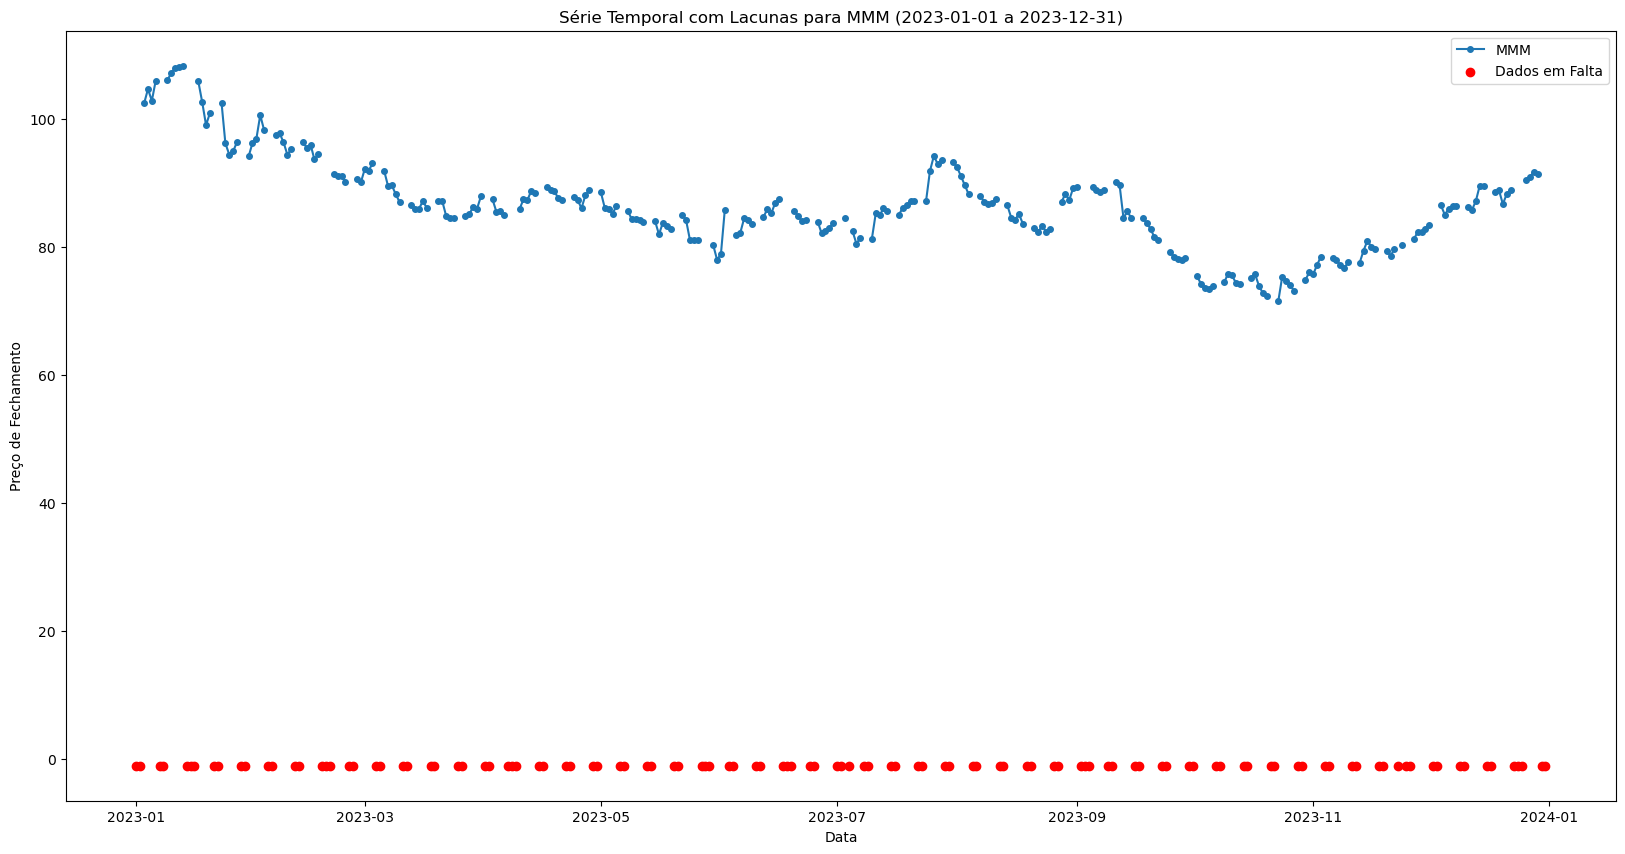

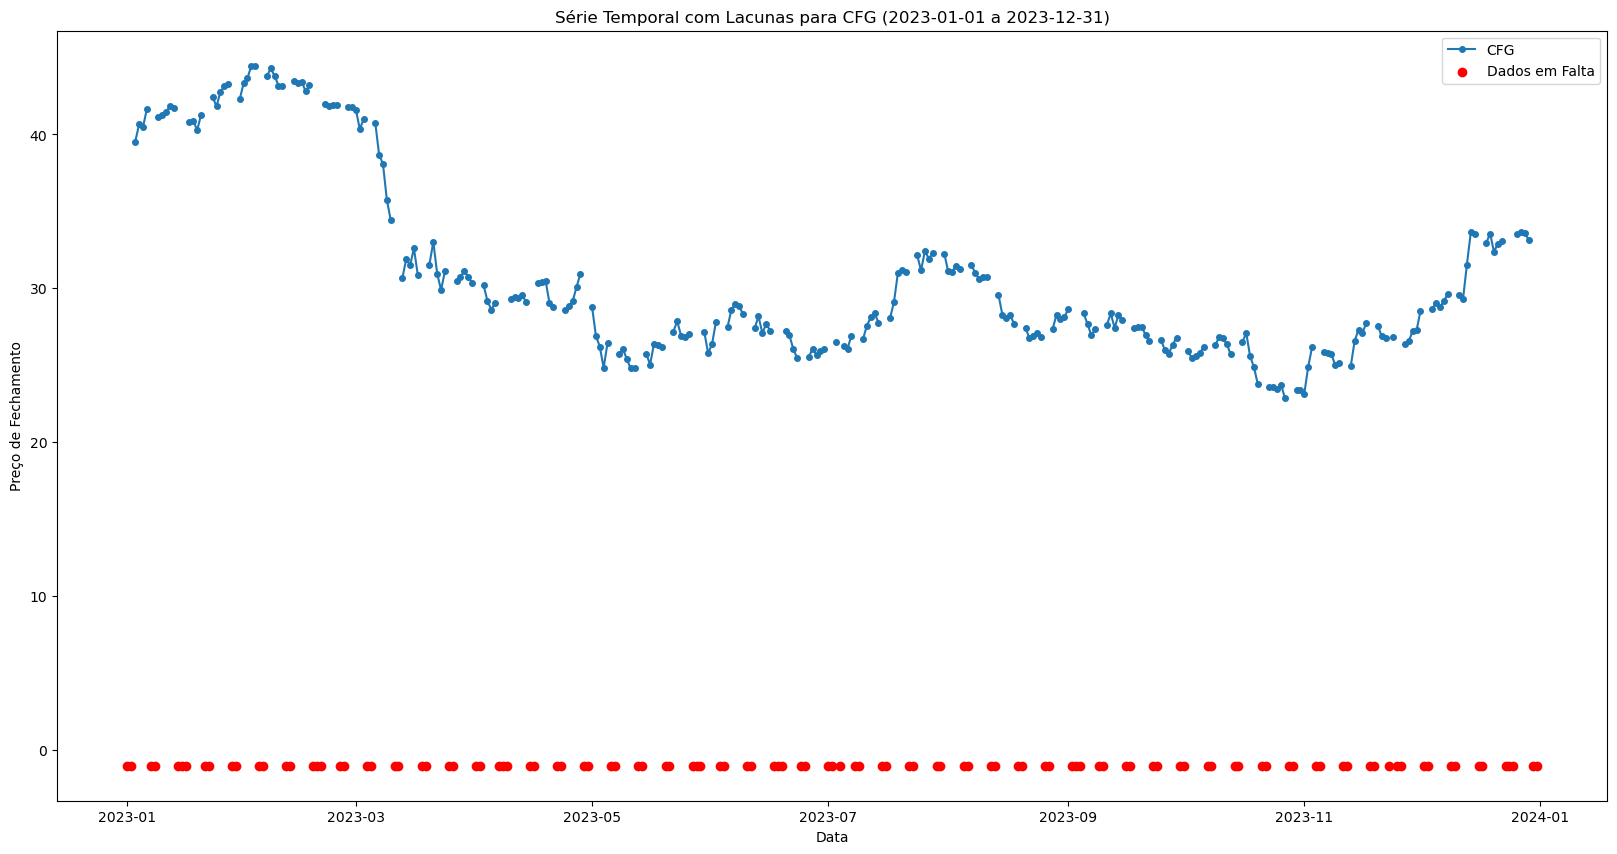

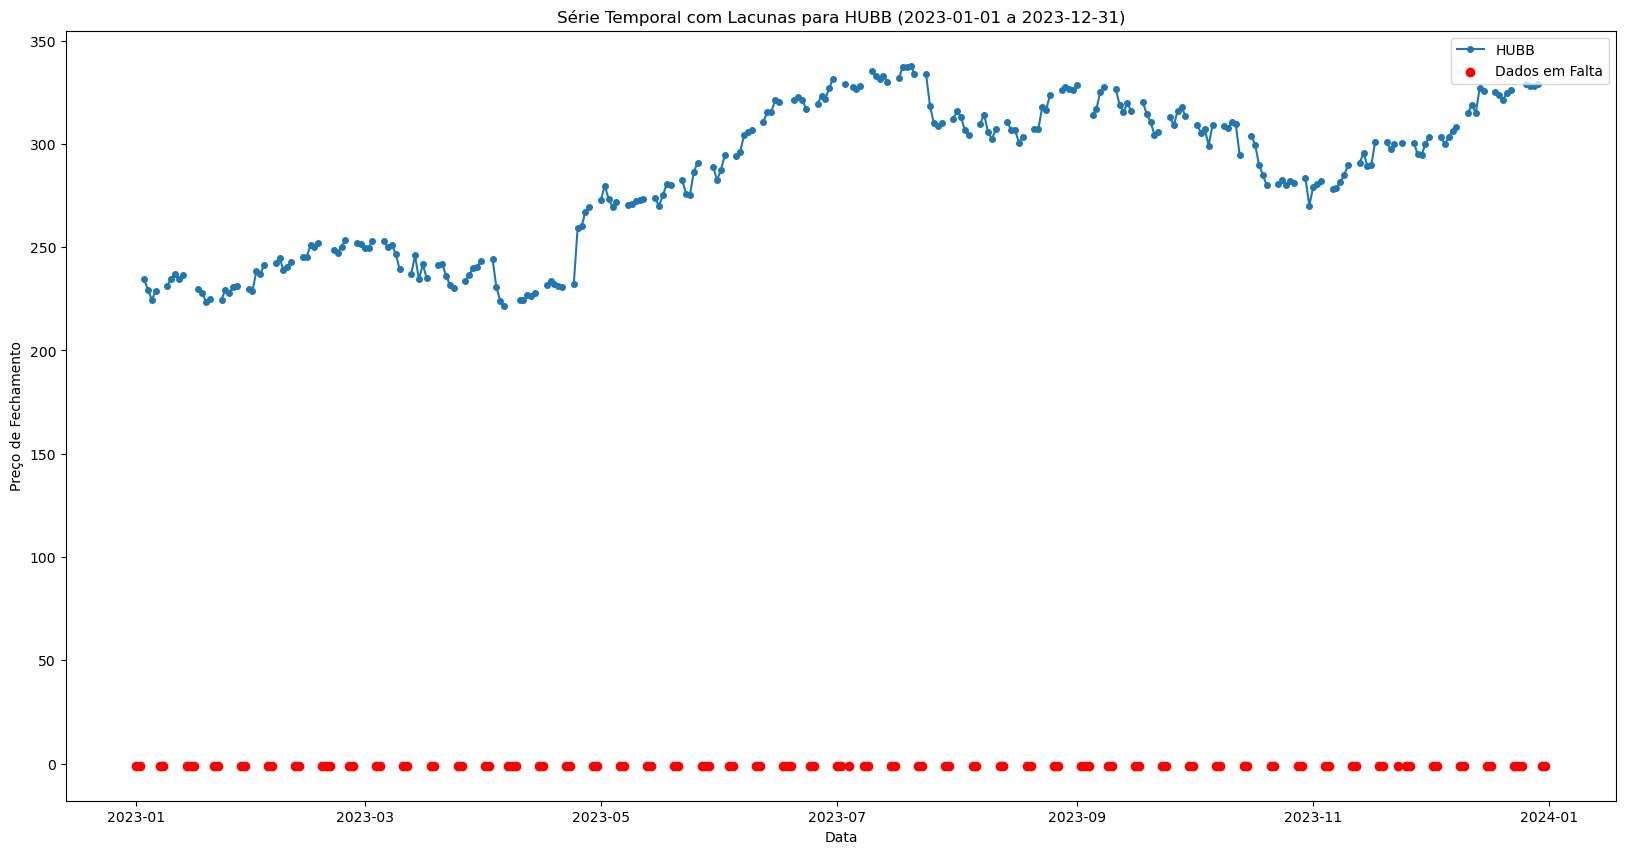

In [27]:
plot_missing_data(df_sp500, ['MMM', 'CFG', 'HUBB'], "2023-01-01", "2023-12-31")

# Criação de Features Temporais <a name = "temp"> </a>
[[voltar ao índice]](#indice)

Após a leitura de alguns estudos, como  o estudo [[PSTK15]](#PSTK15), percebemos que as **features temporais discretas** conseguem fazer com que os modelos obtenham melhores resultados, uma vez que ajudam a analisar padrões, tendências e sinais de compra/venda com base no comportamento histórico dos preços e volumes de negociação. Tendo isto em conta, iremos agrupar os dados do dataset por empresa, de modo a a processar cada ação separadamente, o que é necessário tendo em conta que os indicadres tecnicos são calculados individualmente para cada ativo.

Assim sendo, vamos criar um novo dataset com a adição dos seguintes indicadores:

- **SMA (Simple Moving Average):** Ferramenta simples de análise técnica que suaviza os dados de preços ao criar uma média móvel atualizada constantemente.

$$
\text{SMA}_t = \frac{\sum_{i=t-n+1}^{t} \text{Close}_i}{n}
$$

- **WMA (Weighted Moving Average):** Também uma ferramenta simples de análise técnica, mas que atribui mais peso aos dados mais recentes e menos peso aos mais antigos. Dessa forma, o WMA permite que os valores recentes tenham uma influência maior na média.

$$
\text{WMA}_t = \frac{\sum_{i=1}^{n} (\text{Close}_{t-i+1} \cdot i)}{\sum_{i=1}^{n} i}
$$

- **Momentum:** Mede a velocidade ou intensidade de movimento do preço de um ativo. É calculado pela diferença entre o preço atual e o preço de um período anterior, identificando se o mercado está em tendência de alta ou baixa.

$$
\text{Momentum}_t = \text{Close}_t - \text{Close}_{t-n}
$$

- **Stochastic %K e %D:** Indicadores técnicos que comparam o preço de fechamento atual com a faixa de preços (máximo e mínimo) de um período definido:

 **%K** -> Mede a posição do preço atual em relação à faixa máxima e mínima recente. 
 
**%D** -> Média móvel de 3 períodos do %K, usada para suavizar os dados.
        
$$
\%K_t = \frac{\text{Close}_t - \text{L14}}{\text{H14} - \text{L14}} \cdot 100
$$
$$
\%D_t = \text{Média móvel de 3 períodos de } \%K
$$

- **MACD (Moving Average Convergence Divergence):** Indicador técnico que mede a relação entre duas médias móveis exponenciais (geralmente de 12 e 26 períodos). O MACD ajuda a identificar tendências de alta ou baixa e pontos de reversão no mercado.

$$
\text{MACD} = \text{EMA}_{12} - \text{EMA}_{26}
$$

$$
\text{Signal Line} = \text{EMA}_9(\text{MACD})
$$

- **Larry William's R%:** Indicador que mede a posição do preço de fechamento atual em relação à faixa máxima e mínima dos últimos períodos definidos. Indica condições de sobrecompra ou survenda de um ativo, semelhante ao Stochastic Oscillator.

$$
\text{Williams \%R}_t = \frac{\text{H14} - \text{Close}_t}{\text{H14} - \text{L14}} \cdot -100
$$

- **A/D Oscilator:** Indicador que avalia o fluxo de volume em um ativo com base na relação entre o preço de fechamento e as faixas máxima e mínima. Indica se o mercado está acumulando ou distribuindo o ativo.

$$
\text{MFM}_t = \frac{(\text{Close}_t - \text{Low}_t) - (\text{High}_t - \text{Close}_t)}{\text{High}_t - \text{Low}_t}
$$

$$
\text{MFV}_t = \text{MFM}_t \cdot \text{Volume}_t
$$

$$
\text{A/D Oscillator} = \sum \text{MFV}
$$

- **CCI (Commodity Channel Index):** Indicador que mede a diferença entre o preço típico de um ativo (média dos preços alto, baixo e fechamento) e sua média móvel, ajustada para a volatilidade. É usado para identificar condições de sobrecompra, survenda ou reversões de tendência.

$$
\text{CCI}_t = \frac{\text{Preço Típico}_t - \text{SMA}_\text{Preço Típico}}{0.015 \cdot \text{Desvio Médio}}
$$

A função presente abaixo permite-nos extrair essas features

In [28]:
def calculate_technical_indicators(data):
    grouped = data.groupby('Symbol')
    results = []

    for symbol, group in grouped:
        df = group.copy()

        # Certificar-se de que as colunas necessárias estão presentes
        if {'Close', 'High', 'Low', 'Volume'}.issubset(df.columns):
            # Simple Moving Average (SMA)
            df['SMA_10'] = df['Close'].rolling(window=10).mean()

            # Weighted Moving Average (WMA)
            def wma(series):
                weights = np.arange(1, len(series) + 1)
                return (series * weights).sum() / weights.sum()
            
            df['WMA_10'] = df['Close'].rolling(window=10).apply(wma, raw=True)

            # Momentum
            df['Momentum'] = df['Close'].diff(periods=9)

            # Stochastic %K and %D
            df['L14'] = df['Low'].rolling(window=14).min()
            df['H14'] = df['High'].rolling(window=14).max()
            df['%K'] = ((df['Close'] - df['L14']) / (df['H14'] - df['L14'])) * 100
            df['%D'] = df['%K'].rolling(window=3).mean()

            # Moving Average Convergence Divergence (MACD)
            ema12 = df['Close'].ewm(span=12, adjust=False).mean()
            ema26 = df['Close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = ema12 - ema26
            df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

            # Larry William's R%
            df['Williams_R'] = ((df['H14'] - df['Close']) / (df['H14'] - df['L14'])) * -100

            # Accumulation/Distribution Oscillator (A/D Oscillator)
            df['MFM'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
            df['MFM'] = df['MFM'].fillna(0)  # Lidar com divisões por zero
            df['MFV'] = df['MFM'] * df['Volume']
            df['A/D Oscillator'] = df['MFV'].cumsum()

            # Commodity Channel Index (CCI)
            typical_price = (df['High'] + df['Low'] + df['Close']) / 3
            sma_typical_price = typical_price.rolling(window=20).mean()
            mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())), raw=True)
            df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)        

        df = df.dropna()
        results.append(df)
        
    final_results = pd.concat(results)
    final_results.to_csv("features.csv", index = False)
    print(f"Dataset guardado em 'features.csv.'")

In [29]:
calculate_technical_indicators(df_sp500)

Dataset guardado em 'features.csv.'


Vamos apenas confirmar que os dados foram criados com sucesso e que não há valores em falta:

In [30]:
data = pd.read_csv('features.csv')
data['Date'] = pd.to_datetime(data['Date'])

In [31]:
data.head()

,Date,Close,Adj Close,High,Low,Open,Volume,Symbol,Name,SMA_10,...,H14,%K,%D,MACD,Signal_Line,Williams_R,MFM,MFV,A/D Oscillator,CCI
0,2010-02-01,20.836910,18.662764,20.972818,20.121601,20.143063,5585429,A,Agilent Technologies,21.092990,...,22.432047,35.174414,15.113592,-0.449415,-0.319335,-64.825586,0.680673,3.801853e+06,6.931019e+06,-112.018180
1,2010-02-02,21.101574,18.899822,21.165951,20.808298,20.901287,5884741,A,Agilent Technologies,21.000000,...,22.432047,45.930219,28.100769,-0.415504,-0.338569,-54.069781,0.640004,3.766256e+06,1.069728e+07,-57.752636
2,2010-02-03,21.130186,18.925440,21.380545,21.001431,21.022890,6085634,A,Agilent Technologies,20.922031,...,22.432047,47.093003,42.732545,-0.381918,-0.347239,-52.906997,-0.320756,-1.952002e+06,8.745273e+06,-34.933052
3,2010-02-04,20.793991,18.624329,21.065807,20.701000,20.958511,6632392,A,Agilent Technologies,20.818312,...,22.432047,33.430200,42.151140,-0.378071,-0.353405,-66.569800,-0.490192,-3.251143e+06,5.494131e+06,-66.607859
4,2010-02-05,20.865522,18.688396,20.929899,20.157368,20.679543,9546662,A,Agilent Technologies,20.818312,...,22.253220,39.184945,39.902716,-0.365042,-0.355733,-60.815055,0.833335,7.955571e+06,1.344970e+07,-83.236104


In [32]:
data.isnull().values.any()

False

In [33]:
data.isna().sum()

Date              0
Close             0
Adj Close         0
High              0
Low               0
Open              0
Volume            0
Symbol            0
Name              0
SMA_10            0
WMA_10            0
Momentum          0
L14               0
H14               0
%K                0
%D                0
MACD              0
Signal_Line       0
Williams_R        0
MFM               0
MFV               0
A/D Oscillator    0
CCI               0
dtype: int64

# Organização dos Dados <a name = "od"> </a>
[[voltar ao índice]](#indice)

De modo a que o modelo possa aprender melhor os padrões de cada empresa, decidimos que vamos organizar os  dados por setor de atividade, uma vez que empresas de um mesmo setor tem comportamentos semelhantes. Para o fazer iremos apenas dar merge de 'Sector' que se encontra em df_companies.csv, com este dataset no qual extraimos as features.

In [34]:
# Realizar o merge com base na coluna 'Symbol'
merged_data = data.merge(df_companies[['Symbol', 'Sector']], on = 'Symbol', how = 'left')
merged_data.to_csv('merged_data.csv',index = False)

Agora podemos fazer a leitura do dataset com merge:

In [35]:
merged_data = pd.read_csv("merged_data.csv")

In [36]:
# Ordenar os dados por 'Symbol', 'Date' e 'Sector' para manter a sequência temporal de cada empresa
sorted_data = merged_data.sort_values(['Symbol', 'Date', 'Sector']).reset_index(drop=True)
sorted_data.to_csv('sorted_data.csv', index=False)

In [37]:
data = pd.read_csv("sorted_data.csv")

De modo a ser mais fácil de identificar os diferentes setores, iremos criar uma lista de tuplos que agregem os dados so seguinte modo:

                                (Nome do setor, Dataset de treino, Dataset de teste)

Assim, cada tuplo tem um setor atividade, tal que tanto o Dataset de Treino como o Dataset de Teste contêm todas as empresas que pertencem a esse setor. Relembramos que os Datasets de Treino apenas contem dados dessas empresas que estejam entre 01-0-2010 e 31-12-2023, e os Datasets de Teste entre 01-01-2024 e 31-01-2024.

In [38]:
sectors_list_rf = [
    (sector, 
     group[group['Date'] < '2024-01-01'].drop(columns=['Sector']).reset_index(drop=True),  # Training data for sector
     group[(group['Date'] >= '2024-01-01') & (group['Date'] < '2024-02-01')].drop(columns=['Sector']).reset_index(drop=True))  # January 2024 data for sector
    for sector, group in data.groupby('Sector')
]

De modo a perceber melhor como é que os dados foram guardados vamos fazer uma breve demonstração:

- Nome do Setor: Está guardado na primeira 'casa' do tuplo

In [39]:
print(f"\nSector name: {sectors_list_rf[0][0]}")


Sector name: Basic Materials


- Data de treino: Está guardada na segunda 'casa'

In [40]:
print("\nTraining data:")
sectors_list_rf[0][1]


Training data:


,Date,Close,Adj Close,High,Low,Open,Volume,Symbol,Name,SMA_10,...,H14,%K,%D,MACD,Signal_Line,Williams_R,MFM,MFV,A/D Oscillator,CCI
0,2010-02-01,36.250000,29.489227,36.349998,35.799999,35.950001,1012700,ALB,Albemarle Corporation,36.868000,...,38.889999,16.719214,10.938342,-0.474886,-0.304345,-83.280786,0.636369,644450.562842,-2.496174e+06,-147.605014
1,2010-02-02,36.900002,30.018002,37.119999,35.990002,36.380001,951800,ALB,Albemarle Corporation,36.721000,...,38.889999,37.224006,17.981073,-0.437243,-0.330925,-62.775994,0.610623,581191.079663,-1.914983e+06,-78.784648
2,2010-02-03,36.630001,29.798357,37.299999,36.549999,36.779999,704100,ALB,Albemarle Corporation,36.588000,...,38.889999,28.706636,27.549952,-0.424306,-0.349601,-71.293364,-0.786662,-553888.562012,-2.468872e+06,-55.837162
3,2010-02-04,35.389999,28.789612,36.480000,35.389999,36.220001,486000,ALB,Albemarle Corporation,36.415000,...,38.889999,0.000000,21.976881,-0.508253,-0.381331,-100.000000,-1.000000,-486000.000000,-2.954872e+06,-137.390425
4,2010-02-05,35.160000,28.602510,35.680000,34.490002,35.480000,759400,ALB,Albemarle Corporation,36.322000,...,38.779999,15.617683,14.774773,-0.586578,-0.422381,-84.382317,0.126049,95721.338928,-2.859150e+06,-165.625592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72302,2023-12-22,224.929993,223.339081,224.949997,223.130005,224.050003,470000,VMC,Vulcan Materials Company,222.931998,...,226.839996,88.047533,76.783463,3.705046,3.361942,-11.952467,0.978017,459668.077971,5.201361e+07,90.580050
72303,2023-12-26,225.649994,224.053955,225.940002,224.899994,225.360001,302800,VMC,Vulcan Materials Company,223.610997,...,226.839996,92.553174,86.107623,3.768454,3.443245,-7.446826,0.442296,133927.180962,5.214754e+07,96.237526
72304,2023-12-27,225.820007,224.222778,226.070007,224.460007,225.000000,461700,VMC,Vulcan Materials Company,224.102998,...,226.839996,93.617088,91.405932,3.788750,3.512346,-6.382912,0.689441,318314.961190,5.246586e+07,87.317384
72305,2023-12-28,225.440002,223.845474,226.110001,225.080002,225.889999,427200,VMC,Vulcan Materials Company,224.279999,...,226.839996,90.120014,92.096759,3.731161,3.556109,-9.879986,-0.300969,-128573.897070,5.233728e+07,82.081667


- Data de teste: Está guardada na terceira 'casa'

In [41]:
print("\nData de teste = Janeiro 2024:")
sectors_list_rf[0][2]


Data de teste = Janeiro 2024:


,Date,Close,Adj Close,High,Low,Open,Volume,Symbol,Name,SMA_10,...,H14,%K,%D,MACD,Signal_Line,Williams_R,MFM,MFV,A/D Oscillator,CCI
0,2024-01-02,146.889999,145.214142,149.610001,141.259995,143.000000,1962300,ALB,Albemarle Corporation,147.541998,...,153.539993,77.899652,79.244988,5.146257,4.420014,-22.100348,0.348503,6.838678e+05,8.440108e+07,45.267672
1,2024-01-03,140.179993,138.580704,142.899994,136.699997,142.589996,2731000,ALB,Albemarle Corporation,146.968997,...,153.539993,44.793379,65.020886,4.400281,4.416068,-55.206621,0.122580,3.347655e+05,8.473585e+07,3.982554
2,2024-01-04,135.929993,134.379181,141.080002,135.029999,141.080002,3208000,ALB,Albemarle Corporation,145.668997,...,153.539993,4.862205,42.518412,3.426649,4.218184,-95.137795,-0.702482,-2.253561e+06,8.248229e+07,-24.476948
3,2024-01-05,135.830002,134.280334,138.220001,133.949997,135.419998,2283800,ALB,Albemarle Corporation,144.998997,...,153.539993,9.596760,19.750781,2.616806,3.897908,-90.403240,-0.119437,-2.727692e+05,8.220952e+07,-47.156020
4,2024-01-08,136.580002,135.021774,136.990005,132.750000,134.199997,1879300,ALB,Albemarle Corporation,144.111998,...,153.539993,18.422333,10.960433,2.012321,3.520791,-81.577667,0.806602,1.515848e+06,8.372537e+07,-62.746532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,2024-01-24,219.800003,218.245346,224.270004,219.729996,224.050003,823000,VMC,Vulcan Materials Company,223.915001,...,229.800003,12.434312,43.048248,1.056619,1.653541,-87.565688,-0.969160,-7.976185e+05,5.303083e+07,-90.112863
436,2024-01-25,223.410004,221.829819,223.550003,221.009995,222.460007,655600,VMC,Vulcan Materials Company,223.645001,...,229.800003,37.475552,29.555854,0.976689,1.518170,-62.524448,0.889765,5.833297e+05,5.361415e+07,-33.758810
437,2024-01-26,222.360001,220.787247,224.300003,222.000000,223.410004,691600,VMC,Vulcan Materials Company,223.445001,...,229.800003,26.117209,25.342358,0.819174,1.378371,-73.882791,-0.686956,-4.750991e+05,5.313906e+07,-21.017252
438,2024-01-29,229.369995,227.747650,229.479996,222.089996,222.089996,696900,VMC,Vulcan Materials Company,223.986000,...,229.800003,95.729815,53.107525,1.245631,1.351823,-4.270185,0.970230,6.761532e+05,5.381521e+07,132.841345


Agora iremos repetir exatamente o mesmo processo de divisão de setores, mas para o LSTM, pois estes conjuntos de dados podem sofrer alterações, mas o conceito baso é o mesmo e será usado em ambos os modelos.

In [42]:
sectors_list_lstm = [
    (sector, 
     group[group['Date'] < '2024-01-01'].drop(columns=['Sector']).reset_index(drop=True),  # Training data for sector
     group[(group['Date'] >= '2024-01-01') & (group['Date'] < '2024-02-01')].drop(columns=['Sector']).reset_index(drop=True))  # January 2024 data for sector
    for sector, group in data.groupby('Sector')
]

De modo a comprovar que de facto os dados estão bem divididos em ambos os casos, vamos apenas confirmar se foram criados 11 tuplos, que corresponde ao número de setores existentes:

In [43]:
print(f"Para o Random Forest temos: {len(sectors_list_rf)} setores.")
print(f"Para o LSTM temos: {len(sectors_list_lstm)} setores.")

Para o Random Forest temos: 11 setores.
Para o LSTM temos: 11 setores.


Concluimos que os dados foram divididos com sucesso.

# Random Forest <a name = "rf"> </a>
[[voltar ao índice]](#indice)

A utilização do Random Forest é especialmente apropriada no contexto da previsão de preços de ações devido à sua capacidade de lidar com dados financeiros que apresentam alta variabilidade, não linearidade e relações complexas entre si. O Random Forest foi escolhido, especialmente, pela robustez em cenários de dados heterogéneos. 

Antes de pudermos começar a treinar o modelo é importante destacar que o Random Forest não é capaz de lidar com dados no tipo DateTime, no entanto, é capaz de lidar com dados no formato de inteiros ou floats. Tendo isto em conta iremos alterar a coluna 'Date' de modo a que esta seja subdividida em **Ano**, **Mês** e **Dia**.

In [44]:
def process_date_column(df):
    df['Day'] = pd.to_datetime(df['Date']).dt.day
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    df = df.drop(columns=['Date'])
    return df

In [45]:
for i, (sector, df_train, df_test) in enumerate(sectors_list_rf):
    # Processar a coluna de data
    df_train = process_date_column(df_train)
    df_test = process_date_column(df_test)

    # Atualizar a lista com o resultado processado
    sectors_list_rf[i] = (sector, df_train, df_test)

Vamos apenas confirmar que os dados foram alterados com sucesso. Para isso vamos escolher um conjinto de teste e de treino qualquer:

- Dataset de Treino:

In [46]:
print("Sample of sectors' data:")
print(f"Sector name: {sectors_list_rf[2][0]}")
print("Training data:")
sectors_list_rf[2][1]

Sample of sectors' data:
Sector name: Consumer Cyclical
Training data:


,Close,Adj Close,High,Low,Open,Volume,Symbol,Name,SMA_10,WMA_10,...,MACD,Signal_Line,Williams_R,MFM,MFV,A/D Oscillator,CCI,Day,Month,Year
0,149.770004,149.770004,155.539993,147.250000,153.449997,4615600,ABNB,Airbnb,148.033000,147.360911,...,0.774504,1.086998,-66.368175,-0.392037,-1.809486e+06,-5.503124e+07,26.075923,8,1,2021
1,148.130005,148.130005,150.500000,144.020004,147.990005,2801900,ABNB,Airbnb,147.362001,147.378548,...,0.715540,1.012706,-70.687373,0.268520,7.523649e+05,-5.427887e+07,-2.232758,11,1,2021
2,160.800003,160.800003,163.880005,143.610001,148.080002,8123600,ABNB,Airbnb,148.542001,149.821821,...,1.671901,1.144545,-37.318930,0.696102,5.654858e+06,-4.862401e+07,68.057207,12,1,2021
3,169.990005,169.990005,178.619995,159.350006,160.809998,12529700,ABNB,Airbnb,150.541002,153.721458,...,3.135239,1.542684,-20.735201,0.104308,1.306945e+06,-4.731707e+07,166.932986,13,1,2021
4,180.500000,180.500000,187.419998,174.975006,175.539993,9926500,ABNB,Airbnb,153.748003,159.168549,...,5.084404,2.251028,-13.724709,-0.112094,-1.112697e+06,-4.842977e+07,230.507321,14,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181531,130.000000,127.463387,130.500000,129.410004,129.899994,991500,YUM,Yum! Brands,129.510999,129.815272,...,1.266488,1.083406,-23.821042,0.082566,8.186392e+04,2.688156e+08,82.536837,22,12,2023
181532,130.259995,127.718315,130.710007,129.559998,129.880005,627500,YUM,Yum! Brands,129.873999,129.951453,...,1.278588,1.122442,-20.677217,0.217376,1.364036e+05,2.689520e+08,80.332140,26,12,2023
181533,130.839996,128.286987,131.119995,130.199997,130.449997,1050400,YUM,Yum! Brands,130.150998,130.127089,...,1.319765,1.161907,-13.663897,0.391306,4.110276e+05,2.693630e+08,86.495992,27,12,2023
181534,130.520004,127.973267,131.029999,130.369995,130.839996,882500,YUM,Yum! Brands,130.109999,130.194181,...,1.311460,1.191817,-18.589697,-0.545429,-4.813414e+05,2.688817e+08,76.349171,28,12,2023


- Dataset de Teste:

In [47]:
print("Sample of sectors' data:")
print(f"Sector name: {sectors_list_rf[6][0]}")
print("Training data:")
sectors_list_rf[6][2]

Sample of sectors' data:
Sector name: Healthcare
Training data:


,Close,Adj Close,High,Low,Open,Volume,Symbol,Name,SMA_10,WMA_10,...,MACD,Signal_Line,Williams_R,MFM,MFV,A/D Oscillator,CCI,Day,Month,Year
0,138.750000,138.048569,140.589996,137.910004,138.190002,1441600,A,Agilent Technologies,139.119000,139.268910,...,4.971632,5.404585,-17.485987,-0.373135,-5.379119e+05,4.155521e+08,58.811277,2,1,2024
1,131.160004,130.496948,138.000000,131.070007,138.000000,2074500,A,Agilent Technologies,138.482001,137.821820,...,4.092960,5.142260,-80.834008,-0.974027,-2.020619e+06,4.135315e+08,-24.744524,3,1,2024
2,131.000000,130.337753,131.500000,130.190002,130.550003,2446600,A,Agilent Technologies,137.603001,136.461456,...,3.345134,4.782835,-92.669707,0.236640,5.789629e+05,4.141104e+08,-67.526696,4,1,2024
3,130.559998,129.899994,131.960007,128.619995,130.000000,1394000,A,Agilent Technologies,136.841002,135.180910,...,2.686010,4.363470,-84.627569,0.161674,2.253737e+05,4.143358e+08,-78.352625,5,1,2024
4,133.380005,132.705734,133.570007,129.809998,130.139999,1311400,A,Agilent Technologies,136.285002,134.551638,...,2.363950,3.963566,-62.282046,0.898935,1.178864e+06,4.155147e+08,-53.810737,8,1,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,186.070007,184.663086,189.699997,185.929993,188.809998,1837700,ZTS,Zoetis,192.256003,190.187821,...,-0.097868,1.551115,-98.992701,-0.925722,-1.701199e+06,2.453025e+08,-173.355247,24,1,2024
1236,187.320007,185.903656,187.529999,185.309998,185.529999,2530600,ZTS,Zoetis,191.111003,189.290367,...,-0.411189,1.158655,-86.156962,0.810819,2.051858e+06,2.473543e+08,-153.945040,25,1,2024
1237,191.520004,190.071884,192.880005,188.970001,189.210007,1840200,ZTS,Zoetis,190.592003,189.364731,...,-0.316939,0.863536,-57.231371,0.304348,5.600615e+05,2.479144e+08,-51.288890,26,1,2024
1238,192.759995,191.302505,193.000000,189.960007,191.360001,1669900,ZTS,Zoetis,189.974002,189.758911,...,-0.140568,0.662715,-48.691496,0.842101,1.406225e+06,2.493206e+08,-29.339716,29,1,2024


Concluimos que as alterações foram realizadas com sucesso.

Assim sendo vamos começar a treinar o modelo do Random Forest, para isso deve ter em conta que este foi realizado seguindo o seguinte método:

- **Andar de tuplo em tuplo:** Isto tem como objetivo, tal como foi dito previamente, encontrar os padrões de empresas dentro do mesmo setor, o que nos permite prever melhor os resultados das empresas individualmente no futuro.

- **Dividir os Dados:** Quando vamos buscar os dados de Treino e Teste para cada setor, temos o cuidado de separar o X do Y, sendo que ao X, retiramos os valores do 'Close' e do 'Adj Close', para além de também tirarmos 'Symbol' e 'Name' por serem irreleantes, e para o Y damos apenas o valor do 'Close'.

- **Realizamos Time Series Split Cross Validation no treino:** Deste modo os dados são divididos respeitando a ordem temporal, isto é, o conjunto de treino começa pequeno e aumenta progressivamente, enquanto o conjunto de teste inclui apenas dados subsequentes. Assim, o modelo é treinado com dados do passado e avaliado em dados do futuro, evitando influências de dados futuros no treino.

- **Guardamos os modelos treinados:** Caso seja necessário utiliza-los futuramente

- **Testamos cada Empresa daquele setor no modelo treinado:** Deste modo somos capazes de compreender se o modelo está a ser capaz de prever corretamente ou não resultados futuros.

Listas usadas para guardar valores relevantes:

In [48]:
all_sector_rmse = []
all_sector_mae = []
all_sector_mape = []
company_metrics = []
all_predictions = []

Código para treinar e testar o modelo:

In [49]:
# Loop through each sector in sectors_list with a progress bar
for sector, dataframe, test_dataframe in tqdm(sectors_list_rf, desc="Processing sectors", colour='lightblue'):
    print(f"Processing sector: {sector}")

    # Prepare the sector data
    X = dataframe.drop(columns=['Close', 'Adj Close', 'Symbol', 'Name'])
    y = dataframe['Close']
    
    # Initialize the model
    model = RandomForestRegressor()

    # Perform cross-validation
    tscv = TimeSeriesSplit(n_splits=5)    

    for train_index, test_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)

    # Save the model for the sector
    os.makedirs("sector_models", exist_ok=True)
    
    model_filename = f"sector_models/{sector}_model.pkl"
    dump(model, model_filename)
    print(f"Model for sector '{sector}' saved as {model_filename}")

    sector_rmse = []
    sector_mae = []
    sector_mape = []

    # Loop through companies in the sector
    companies = test_dataframe['Symbol'].unique()
    for company in companies:
        company_data = test_dataframe[test_dataframe['Symbol'] == company]
        X_company = company_data.drop(columns=['Close', 'Adj Close', 'Symbol', 'Name'])
        y_company = company_data['Close']
        
        y_pred = model.predict(X_company)

        # Calculate company metrics
        rmse_company = np.sqrt(mean_squared_error(y_company, y_pred))
        mae_company = mean_absolute_error(y_company, y_pred)
        mape_company = np.mean(np.abs((y_company - y_pred) / y_company)) * 100

        # Calculate daily returns
        company_data['Predicted_Close'] = y_pred
        company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
        company_data['Sector'] = sector
        company_data['Company'] = company
        all_predictions.append(company_data)

        # Store daily return metrics
        mean_predicted_return = company_data['Predicted_Return'].mean()
        std_predicted_return = company_data['Predicted_Return'].std()
        sharpe_ratio = mean_predicted_return / std_predicted_return if std_predicted_return != 0 else 0

        # Append to company metrics list
        company_metrics.append({
            'Sector': sector,
            'Company': company,
            'RMSE': rmse_company,
            'MAE': mae_company,
            'MAPE': mape_company,
            'Mean_Return': mean_predicted_return,
            'Std_Return': std_predicted_return,
            'Sharpe_Ratio': sharpe_ratio
        })

        # Append metrics to sector lists
        sector_rmse.append(rmse_company)
        sector_mae.append(mae_company)
        sector_mape.append(mape_company)

        print(f"Company: {company}")
        print(f"RMSE: {rmse_company:.3f}")
        print(f"MAE: {mae_company:.3f}")
        print(f"MAPE: {mape_company:.3f}%")
        print(f"Mean Return: {mean_predicted_return:.4f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

    # Sector-level metrics
    mean_sector_rmse = np.mean(sector_rmse)
    mean_sector_mae = np.mean(sector_mae)
    mean_sector_mape = np.mean(sector_mape)
    print(f"Mean RMSE for sector {sector}: {mean_sector_rmse:.3f}")
    print(f"Mean MAE for sector {sector}: {mean_sector_mae:.3f}")
    print(f"Mean MAPE for sector {sector}: {mean_sector_mape:.3f}%")
    
    # Append sector metrics
    all_sector_rmse.append(mean_sector_rmse)
    all_sector_mae.append(mean_sector_mae)
    all_sector_mape.append(mean_sector_mape)

Processing sectors:   0%|          | 0/11 [00:00<?, ?it/s]

Processing sector: Basic Materials
Model for sector 'Basic Materials' saved as sector_models/Basic Materials_model.pkl
Company: ALB
RMSE: 0.476
MAE: 0.334
MAPE: 0.264%
Mean Return: -0.0105
Sharpe Ratio: -0.4148
Company: APD
RMSE: 0.307
MAE: 0.274
MAPE: 0.103%
Mean Return: -0.0026
Sharpe Ratio: -0.2749
Company: CE
RMSE: 0.159
MAE: 0.128
MAPE: 0.087%
Mean Return: -0.0014
Sharpe Ratio: -0.1027
Company: CF
RMSE: 0.047
MAE: 0.037
MAPE: 0.048%
Mean Return: -0.0027
Sharpe Ratio: -0.2415
Company: CTVA
RMSE: 0.024
MAE: 0.018
MAPE: 0.039%
Mean Return: -0.0030
Sharpe Ratio: -0.2971
Company: DD
RMSE: 0.055
MAE: 0.049
MAPE: 0.067%
Mean Return: -0.0103
Sharpe Ratio: -0.3176
Company: DOW
RMSE: 0.026
MAE: 0.021
MAPE: 0.039%
Mean Return: -0.0007
Sharpe Ratio: -0.0554
Company: ECL
RMSE: 0.303
MAE: 0.257
MAPE: 0.130%
Mean Return: 0.0007
Sharpe Ratio: 0.0964
Company: EMN
RMSE: 0.077
MAE: 0.054
MAPE: 0.063%
Mean Return: -0.0025
Sharpe Ratio: -0.2303
Company: FCX
RMSE: 0.036
MAE: 0.029
MAPE: 0.072%
Mean Ret

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: STLD
RMSE: 0.140
MAE: 0.107
MAPE: 0.093%
Mean Return: 0.0017
Sharpe Ratio: 0.1034
Company: VMC
RMSE: 0.343
MAE: 0.261
MAPE: 0.116%
Mean Return: 0.0018
Sharpe Ratio: 0.1538
Mean RMSE for sector Basic Materials: 0.668
Mean MAE for sector Basic Materials: 0.529
Mean MAPE for sector Basic Materials: 0.170%
Processing sector: Communication Services
Model for sector 'Communication Services' saved as sector_models/Communication Services_model.pkl
Company: CHTR
RMSE: 0.958
MAE: 0.807
MAPE: 0.216%
Mean Return: -0.0017
Sharpe Ratio: -0.1194
Company: CMCSA
RMSE: 0.077
MAE: 0.043
MAPE: 0.097%
Mean Return: 0.0036
Sharpe Ratio: 0.2575
Company: DIS
RMSE: 0.167
MAE: 0.128
MAPE: 0.139%
Mean Return: 0.0036
Sharpe Ratio: 0.2651
Company: EA
RMSE: 0.135
MAE: 0.104
MAPE: 0.075%
Mean Return: 0.0007
Sharpe Ratio: 0.1309
Company: FOX
RMSE: 0.019
MAE: 0.014
MAPE: 0.049%
Mean Return: 0.0031
Sharpe Ratio: 0.3956
Company: FOXA
RMSE: 0.025
MAE: 0.020
MAPE: 0.066%
Mean Return: 0.0033
Sharpe Ratio: 0.3780
Co

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: TTWO
RMSE: 0.307
MAE: 0.237
MAPE: 0.145%
Mean Return: 0.0024
Sharpe Ratio: 0.3467
Company: VZ
RMSE: 0.044
MAE: 0.034
MAPE: 0.084%
Mean Return: 0.0049
Sharpe Ratio: 0.2356
Company: WBD
RMSE: 0.023
MAE: 0.018
MAPE: 0.171%
Mean Return: -0.0073
Sharpe Ratio: -0.3538
Mean RMSE for sector Communication Services: 0.284
Mean MAE for sector Communication Services: 0.218
Mean MAPE for sector Communication Services: 0.126%
Processing sector: Consumer Cyclical
Model for sector 'Consumer Cyclical' saved as sector_models/Consumer Cyclical_model.pkl
Company: ABNB
RMSE: 0.145
MAE: 0.106
MAPE: 0.076%
Mean Return: 0.0057
Sharpe Ratio: 0.3145
Company: AMCR
RMSE: 0.013
MAE: 0.009
MAPE: 0.095%
Mean Return: -0.0010
Sharpe Ratio: -0.0990
Company: AMZN
RMSE: 0.122
MAE: 0.093
MAPE: 0.060%
Mean Return: 0.0032
Sharpe Ratio: 0.2473
Company: APTV
RMSE: 0.088
MAE: 0.070
MAPE: 0.085%
Mean Return: -0.0018
Sharpe Ratio: -0.0866
Company: AVY
RMSE: 0.200
MAE: 0.156
MAPE: 0.079%
Mean Return: 0.0004
Sharpe Ratio:

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: GM
RMSE: 0.029
MAE: 0.022
MAPE: 0.061%
Mean Return: 0.0031
Sharpe Ratio: 0.1380
Company: GPC
RMSE: 0.092
MAE: 0.072
MAPE: 0.051%
Mean Return: 0.0019
Sharpe Ratio: 0.2268
Company: HAS
RMSE: 0.033
MAE: 0.027
MAPE: 0.056%
Mean Return: 0.0009
Sharpe Ratio: 0.0482
Company: HD
RMSE: 0.487
MAE: 0.369
MAPE: 0.105%
Mean Return: 0.0020
Sharpe Ratio: 0.1641
Company: HLT
RMSE: 0.169
MAE: 0.136
MAPE: 0.074%
Mean Return: 0.0039
Sharpe Ratio: 0.5914
Company: IP
RMSE: 0.018
MAE: 0.013
MAPE: 0.037%
Mean Return: -0.0002
Sharpe Ratio: -0.0139
Company: KMX
RMSE: 0.060
MAE: 0.046
MAPE: 0.065%
Mean Return: -0.0023
Sharpe Ratio: -0.1061
Company: LEN
RMSE: 0.153
MAE: 0.129
MAPE: 0.086%
Mean Return: 0.0014
Sharpe Ratio: 0.0756
Company: LKQ
RMSE: 0.029
MAE: 0.019
MAPE: 0.040%
Mean Return: 0.0004
Sharpe Ratio: 0.0418
Company: LOW
RMSE: 0.265
MAE: 0.207
MAPE: 0.096%
Mean Return: -0.0010
Sharpe Ratio: -0.0845
Company: LULU
RMSE: 0.836
MAE: 0.706
MAPE: 0.146%
Mean Return: -0.0024
Sharpe Ratio: -0.2386
Comp

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: ORLY
RMSE: 2.082
MAE: 1.603
MAPE: 0.163%
Mean Return: 0.0050
Sharpe Ratio: 0.4366
Company: PHM
RMSE: 0.082
MAE: 0.072
MAPE: 0.068%
Mean Return: 0.0022
Sharpe Ratio: 0.1207
Company: PKG
RMSE: 0.080
MAE: 0.059
MAPE: 0.036%
Mean Return: 0.0016
Sharpe Ratio: 0.1404
Company: RCL
RMSE: 0.090
MAE: 0.071
MAPE: 0.058%
Mean Return: 0.0028
Sharpe Ratio: 0.1603
Company: RL
RMSE: 0.136
MAE: 0.111
MAPE: 0.078%
Mean Return: 0.0004
Sharpe Ratio: 0.0273
Company: ROL
RMSE: 0.033
MAE: 0.022
MAPE: 0.051%
Mean Return: 0.0004
Sharpe Ratio: 0.0404
Company: ROST
RMSE: 0.137
MAE: 0.104
MAPE: 0.076%
Mean Return: 0.0018
Sharpe Ratio: 0.2385
Company: SBUX
RMSE: 0.053
MAE: 0.043
MAPE: 0.046%
Mean Return: 0.0002
Sharpe Ratio: 0.0211
Company: TJX
RMSE: 0.063
MAE: 0.051
MAPE: 0.055%
Mean Return: 0.0019
Sharpe Ratio: 0.2277
Company: TPR
RMSE: 0.028
MAE: 0.023
MAPE: 0.061%
Mean Return: 0.0019
Sharpe Ratio: 0.1104
Company: TSCO
RMSE: 0.330
MAE: 0.245
MAPE: 0.110%
Mean Return: 0.0026
Sharpe Ratio: 0.2354
Company

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: KR
RMSE: 0.023
MAE: 0.021
MAPE: 0.045%
Mean Return: 0.0004
Sharpe Ratio: 0.0725
Company: KVUE
RMSE: 0.029
MAE: 0.024
MAPE: 0.113%
Mean Return: -0.0015
Sharpe Ratio: -0.1109
Company: LW
RMSE: 0.167
MAE: 0.106
MAPE: 0.099%
Mean Return: -0.0014
Sharpe Ratio: -0.1199
Company: MDLZ
RMSE: 0.027
MAE: 0.022
MAPE: 0.030%
Mean Return: 0.0018
Sharpe Ratio: 0.2547
Company: MKC
RMSE: 0.027
MAE: 0.019
MAPE: 0.029%
Mean Return: -0.0001
Sharpe Ratio: -0.0066
Company: MNST
RMSE: 0.033
MAE: 0.026
MAPE: 0.046%
Mean Return: -0.0030
Sharpe Ratio: -0.3305
Company: MO
RMSE: 0.017
MAE: 0.013
MAPE: 0.032%
Mean Return: -0.0014
Sharpe Ratio: -0.1760
Company: PEP
RMSE: 0.290
MAE: 0.242
MAPE: 0.144%
Mean Return: -0.0009
Sharpe Ratio: -0.1245
Company: PG
RMSE: 0.096
MAE: 0.072
MAPE: 0.048%
Mean Return: 0.0030
Sharpe Ratio: 0.2551
Company: PM
RMSE: 0.045
MAE: 0.036
MAPE: 0.038%
Mean Return: -0.0021
Sharpe Ratio: -0.3275
Company: SJM
RMSE: 0.110
MAE: 0.087
MAPE: 0.067%
Mean Return: 0.0014
Sharpe Ratio: 0.125

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: PSX
RMSE: 0.259
MAE: 0.208
MAPE: 0.155%
Mean Return: 0.0030
Sharpe Ratio: 0.1970
Company: SLB
RMSE: 0.052
MAE: 0.038
MAPE: 0.075%
Mean Return: -0.0024
Sharpe Ratio: -0.0959
Company: TRGP
RMSE: 0.071
MAE: 0.056
MAPE: 0.066%
Mean Return: 0.0004
Sharpe Ratio: 0.0369
Company: VLO
RMSE: 0.294
MAE: 0.216
MAPE: 0.163%
Mean Return: 0.0044
Sharpe Ratio: 0.2390
Company: WMB
RMSE: 0.031
MAE: 0.025
MAPE: 0.071%
Mean Return: -0.0004
Sharpe Ratio: -0.0347
Company: XOM
RMSE: 0.109
MAE: 0.081
MAPE: 0.080%
Mean Return: 0.0011
Sharpe Ratio: 0.0927
Mean RMSE for sector Energy: 0.184
Mean MAE for sector Energy: 0.125
Mean MAPE for sector Energy: 0.120%
Processing sector: Financial Services


C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Model for sector 'Financial Services' saved as sector_models/Financial Services_model.pkl
Company: ACGL
RMSE: 0.027
MAE: 0.022
MAPE: 0.028%
Mean Return: 0.0034
Sharpe Ratio: 0.3709
Company: AFL
RMSE: 0.033
MAE: 0.027
MAPE: 0.032%
Mean Return: 0.0016
Sharpe Ratio: 0.1455
Company: AIG
RMSE: 0.031
MAE: 0.024
MAPE: 0.035%
Mean Return: 0.0012
Sharpe Ratio: 0.1493
Company: AIZ
RMSE: 0.106
MAE: 0.076
MAPE: 0.046%
Mean Return: 0.0001
Sharpe Ratio: 0.0169
Company: AJG
RMSE: 0.286
MAE: 0.211
MAPE: 0.091%
Mean Return: 0.0013
Sharpe Ratio: 0.1347
Company: ALL
RMSE: 0.102
MAE: 0.080
MAPE: 0.053%
Mean Return: 0.0045
Sharpe Ratio: 0.4823
Company: AMP
RMSE: 0.847
MAE: 0.553
MAPE: 0.144%
Mean Return: 0.0021
Sharpe Ratio: 0.2332
Company: AON
RMSE: 0.290
MAE: 0.222
MAPE: 0.075%
Mean Return: 0.0019
Sharpe Ratio: 0.1863
Company: AXP
RMSE: 0.242
MAE: 0.143
MAPE: 0.075%
Mean Return: 0.0045
Sharpe Ratio: 0.2230
Company: BAC
RMSE: 0.017
MAE: 0.014
MAPE: 0.042%
Mean Return: 0.0014
Sharpe Ratio: 0.1027
Company: 

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: BRK-B
RMSE: 0.439
MAE: 0.339
MAPE: 0.092%
Mean Return: 0.0036
Sharpe Ratio: 0.4561
Company: BRO
RMSE: 0.025
MAE: 0.021
MAPE: 0.028%
Mean Return: 0.0054
Sharpe Ratio: 0.3168
Company: BX
RMSE: 0.116
MAE: 0.083
MAPE: 0.068%
Mean Return: -0.0003
Sharpe Ratio: -0.0187
Company: C
RMSE: 0.049
MAE: 0.029
MAPE: 0.055%
Mean Return: 0.0040
Sharpe Ratio: 0.2371
Company: CB
RMSE: 0.136
MAE: 0.116
MAPE: 0.050%
Mean Return: 0.0036
Sharpe Ratio: 0.4285
Company: CBOE
RMSE: 0.169
MAE: 0.128
MAPE: 0.070%
Mean Return: 0.0015
Sharpe Ratio: 0.1227
Company: CFG
RMSE: 0.019
MAE: 0.014
MAPE: 0.042%
Mean Return: 0.0014
Sharpe Ratio: 0.0724
Company: CINF
RMSE: 0.048
MAE: 0.040
MAPE: 0.037%
Mean Return: 0.0030
Sharpe Ratio: 0.3450
Company: CME
RMSE: 0.134
MAE: 0.122
MAPE: 0.060%
Mean Return: -0.0007
Sharpe Ratio: -0.0562
Company: COF
RMSE: 0.104
MAE: 0.077
MAPE: 0.058%
Mean Return: 0.0027
Sharpe Ratio: 0.1626
Company: DFS
RMSE: 0.094
MAE: 0.051
MAPE: 0.049%
Mean Return: -0.0016
Sharpe Ratio: -0.0551
Comp

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: FITB
RMSE: 0.024
MAE: 0.017
MAPE: 0.051%
Mean Return: 0.0011
Sharpe Ratio: 0.0671
Company: GL
RMSE: 0.069
MAE: 0.051
MAPE: 0.042%
Mean Return: 0.0010
Sharpe Ratio: 0.1335
Company: GS
RMSE: 0.464
MAE: 0.378
MAPE: 0.099%
Mean Return: -0.0001
Sharpe Ratio: -0.0145
Company: HBAN
RMSE: 0.013
MAE: 0.011
MAPE: 0.084%
Mean Return: 0.0011
Sharpe Ratio: 0.0658
Company: HIG
RMSE: 0.033
MAE: 0.027
MAPE: 0.032%
Mean Return: 0.0039
Sharpe Ratio: 0.5010
Company: ICE
RMSE: 0.079
MAE: 0.057
MAPE: 0.045%
Mean Return: 0.0011
Sharpe Ratio: 0.1478
Company: IVZ
RMSE: 0.016
MAE: 0.012
MAPE: 0.068%
Mean Return: -0.0042
Sharpe Ratio: -0.1636
Company: JPM
RMSE: 0.147
MAE: 0.097
MAPE: 0.057%
Mean Return: 0.0013
Sharpe Ratio: 0.1522
Company: KEY
RMSE: 0.016
MAE: 0.012
MAPE: 0.085%
Mean Return: 0.0015
Sharpe Ratio: 0.0669
Company: KKR
RMSE: 0.033
MAE: 0.027
MAPE: 0.033%
Mean Return: 0.0041
Sharpe Ratio: 0.3358
Company: L
RMSE: 0.043
MAE: 0.032
MAPE: 0.045%
Mean Return: 0.0025
Sharpe Ratio: 0.5377
Company:

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: MMC
RMSE: 0.118
MAE: 0.095
MAPE: 0.049%
Mean Return: 0.0008
Sharpe Ratio: 0.0740
Company: MS
RMSE: 0.033
MAE: 0.026
MAPE: 0.029%
Mean Return: -0.0035
Sharpe Ratio: -0.2511
Company: MSCI
RMSE: 2.822
MAE: 1.394
MAPE: 0.244%
Mean Return: 0.0034
Sharpe Ratio: 0.1606
Company: MTB
RMSE: 0.101
MAE: 0.081
MAPE: 0.059%
Mean Return: 0.0018
Sharpe Ratio: 0.1092
Company: NDAQ
RMSE: 0.016
MAE: 0.013
MAPE: 0.023%
Mean Return: 0.0015
Sharpe Ratio: 0.1634
Company: NTRS
RMSE: 0.096
MAE: 0.040
MAPE: 0.048%
Mean Return: -0.0025
Sharpe Ratio: -0.2266
Company: PFG
RMSE: 0.036
MAE: 0.029
MAPE: 0.037%
Mean Return: 0.0011
Sharpe Ratio: 0.1180
Company: PGR
RMSE: 0.112
MAE: 0.082
MAPE: 0.048%
Mean Return: 0.0057
Sharpe Ratio: 0.4828
Company: PNC
RMSE: 0.122
MAE: 0.090
MAPE: 0.059%
Mean Return: -0.0007
Sharpe Ratio: -0.0434
Company: PRU
RMSE: 0.039
MAE: 0.031
MAPE: 0.030%
Mean Return: 0.0011
Sharpe Ratio: 0.1280
Company: PYPL
RMSE: 0.157
MAE: 0.090
MAPE: 0.147%
Mean Return: 0.0023
Sharpe Ratio: 0.0748
C

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: SYF
RMSE: 0.037
MAE: 0.026
MAPE: 0.068%
Mean Return: 0.0025
Sharpe Ratio: 0.1378
Company: TFC
RMSE: 0.058
MAE: 0.024
MAPE: 0.065%
Mean Return: 0.0011
Sharpe Ratio: 0.0627
Company: TROW
RMSE: 0.100
MAE: 0.065
MAPE: 0.060%
Mean Return: 0.0019
Sharpe Ratio: 0.1365
Company: TRV
RMSE: 0.115
MAE: 0.092
MAPE: 0.045%
Mean Return: 0.0058
Sharpe Ratio: 0.3641
Company: USB
RMSE: 0.045
MAE: 0.029
MAPE: 0.070%
Mean Return: -0.0006
Sharpe Ratio: -0.0368
Company: V
RMSE: 0.231
MAE: 0.176
MAPE: 0.066%
Mean Return: 0.0037
Sharpe Ratio: 0.4711
Company: WFC
RMSE: 0.026
MAE: 0.020
MAPE: 0.041%
Mean Return: 0.0020
Sharpe Ratio: 0.1339
Company: WRB
RMSE: 0.040
MAE: 0.024
MAPE: 0.047%
Mean Return: 0.0067
Sharpe Ratio: 0.3321
Company: WTW
RMSE: 0.236
MAE: 0.207
MAPE: 0.084%
Mean Return: 0.0017
Sharpe Ratio: 0.1939
Mean RMSE for sector Financial Services: 0.230
Mean MAE for sector Financial Services: 0.166
Mean MAPE for sector Financial Services: 0.067%
Processing sector: Healthcare
Model for sector '

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: COO
RMSE: 0.053
MAE: 0.039
MAPE: 0.041%
Mean Return: 0.0005
Sharpe Ratio: 0.0314
Company: COR
RMSE: 0.144
MAE: 0.120
MAPE: 0.056%
Mean Return: 0.0030
Sharpe Ratio: 0.4358
Company: CRL
RMSE: 0.271
MAE: 0.178
MAPE: 0.083%
Mean Return: -0.0021
Sharpe Ratio: -0.0953
Company: CTLT
RMSE: 0.052
MAE: 0.032
MAPE: 0.068%
Mean Return: 0.0090
Sharpe Ratio: 0.3484
Company: CVS
RMSE: 0.040
MAE: 0.026
MAPE: 0.034%
Mean Return: -0.0046
Sharpe Ratio: -0.2971
Company: DGX
RMSE: 0.084
MAE: 0.058
MAPE: 0.042%
Mean Return: -0.0047
Sharpe Ratio: -0.4146
Company: DHR
RMSE: 0.406
MAE: 0.195
MAPE: 0.085%
Mean Return: 0.0023
Sharpe Ratio: 0.1361
Company: DVA
RMSE: 0.054
MAE: 0.046
MAPE: 0.043%
Mean Return: 0.0005
Sharpe Ratio: 0.0330
Company: DXCM
RMSE: 0.114
MAE: 0.089
MAPE: 0.071%
Mean Return: -0.0007
Sharpe Ratio: -0.0343
Company: ELV
RMSE: 0.760
MAE: 0.549
MAPE: 0.115%
Mean Return: 0.0014
Sharpe Ratio: 0.1568
Company: EW
RMSE: 0.035
MAE: 0.026
MAPE: 0.035%
Mean Return: -0.0010
Sharpe Ratio: -0.0638

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: HCA
RMSE: 0.216
MAE: 0.173
MAPE: 0.061%
Mean Return: 0.0050
Sharpe Ratio: 0.2950
Company: HOLX
RMSE: 0.036
MAE: 0.025
MAPE: 0.034%
Mean Return: 0.0018
Sharpe Ratio: 0.2441
Company: HSIC
RMSE: 0.034
MAE: 0.028
MAPE: 0.037%
Mean Return: -0.0005
Sharpe Ratio: -0.0484
Company: HUM
RMSE: 0.622
MAE: 0.454
MAPE: 0.112%
Mean Return: -0.0110
Sharpe Ratio: -0.3177
Company: IDXX
RMSE: 1.290
MAE: 0.977
MAPE: 0.184%
Mean Return: -0.0024
Sharpe Ratio: -0.1547
Company: INCY
RMSE: 0.046
MAE: 0.032
MAPE: 0.050%
Mean Return: -0.0050
Sharpe Ratio: -0.4529
Company: IQV
RMSE: 0.218
MAE: 0.141
MAPE: 0.064%
Mean Return: -0.0030
Sharpe Ratio: -0.2110
Company: ISRG
RMSE: 0.691
MAE: 0.465
MAPE: 0.128%
Mean Return: 0.0074
Sharpe Ratio: 0.2912
Company: JNJ
RMSE: 0.074
MAE: 0.067
MAPE: 0.042%
Mean Return: -0.0004
Sharpe Ratio: -0.0580
Company: LH
RMSE: 0.159
MAE: 0.137
MAPE: 0.061%
Mean Return: -0.0014
Sharpe Ratio: -0.1346
Company: LLY
RMSE: 1.690
MAE: 1.383
MAPE: 0.220%
Mean Return: 0.0050
Sharpe Ratio:

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: MRK
RMSE: 0.082
MAE: 0.055
MAPE: 0.047%
Mean Return: 0.0039
Sharpe Ratio: 0.5975
Company: MRNA
RMSE: 0.190
MAE: 0.128
MAPE: 0.119%
Mean Return: -0.0049
Sharpe Ratio: -0.2113
Company: MTD
RMSE: 6.152
MAE: 4.923
MAPE: 0.419%
Mean Return: 0.0010
Sharpe Ratio: 0.0621
Company: PFE
RMSE: 0.029
MAE: 0.022
MAPE: 0.075%
Mean Return: -0.0050
Sharpe Ratio: -0.4384
Company: PODD
RMSE: 0.293
MAE: 0.222
MAPE: 0.111%
Mean Return: -0.0040
Sharpe Ratio: -0.1704
Company: REGN
RMSE: 7.842
MAE: 5.884
MAPE: 0.635%
Mean Return: 0.0037
Sharpe Ratio: 0.6122
Company: RMD
RMSE: 0.238
MAE: 0.130
MAPE: 0.072%
Mean Return: 0.0060
Sharpe Ratio: 0.2321
Company: RVTY
RMSE: 0.126
MAE: 0.068
MAPE: 0.062%
Mean Return: 0.0005
Sharpe Ratio: 0.0282
Company: STE
RMSE: 0.164
MAE: 0.138
MAPE: 0.063%
Mean Return: 0.0002
Sharpe Ratio: 0.0231
Company: SYK
RMSE: 0.286
MAE: 0.228
MAPE: 0.074%
Mean Return: 0.0035
Sharpe Ratio: 0.4077
Company: TECH
RMSE: 0.047
MAE: 0.036
MAPE: 0.049%
Mean Return: -0.0026
Sharpe Ratio: -0.13

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: VTRS
RMSE: 0.024
MAE: 0.018
MAPE: 0.151%
Mean Return: 0.0022
Sharpe Ratio: 0.1097
Company: WAT
RMSE: 0.558
MAE: 0.363
MAPE: 0.117%
Mean Return: 0.0002
Sharpe Ratio: 0.0072
Company: WBA
RMSE: 0.045
MAE: 0.033
MAPE: 0.137%
Mean Return: -0.0081
Sharpe Ratio: -0.3273
Company: WST
RMSE: 0.538
MAE: 0.401
MAPE: 0.114%
Mean Return: 0.0041
Sharpe Ratio: 0.2558
Company: ZBH
RMSE: 0.088
MAE: 0.067
MAPE: 0.055%
Mean Return: 0.0004
Sharpe Ratio: 0.0562
Company: ZTS
RMSE: 0.136
MAE: 0.103
MAPE: 0.054%
Mean Return: -0.0013
Sharpe Ratio: -0.1012
Mean RMSE for sector Healthcare: 0.482
Mean MAE for sector Healthcare: 0.363
Mean MAPE for sector Healthcare: 0.090%
Processing sector: Industrials
Model for sector 'Industrials' saved as sector_models/Industrials_model.pkl
Company: ALLE
RMSE: 0.067
MAE: 0.058
MAPE: 0.047%
Mean Return: 0.0008
Sharpe Ratio: 0.0638
Company: AME
RMSE: 0.091
MAE: 0.079
MAPE: 0.049%
Mean Return: 0.0010
Sharpe Ratio: 0.1120
Company: AOS
RMSE: 0.045
MAE: 0.038
MAPE: 0.047%
M

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: EMR
RMSE: 0.041
MAE: 0.034
MAPE: 0.036%
Mean Return: -0.0006
Sharpe Ratio: -0.0572
Company: ETN
RMSE: 0.179
MAE: 0.145
MAPE: 0.060%
Mean Return: 0.0025
Sharpe Ratio: 0.2261
Company: EXPD
RMSE: 0.047
MAE: 0.036
MAPE: 0.029%
Mean Return: 0.0007
Sharpe Ratio: 0.0543
Company: FAST
RMSE: 0.027
MAE: 0.022
MAPE: 0.033%
Mean Return: 0.0046
Sharpe Ratio: 0.2429
Company: FDX
RMSE: 0.145
MAE: 0.112
MAPE: 0.045%
Mean Return: -0.0017
Sharpe Ratio: -0.1603
Company: GD
RMSE: 0.283
MAE: 0.172
MAPE: 0.067%
Mean Return: 0.0021
Sharpe Ratio: 0.1411
Company: GE
RMSE: 0.066
MAE: 0.053
MAPE: 0.052%
Mean Return: 0.0033
Sharpe Ratio: 0.3441
Company: GNRC
RMSE: 0.078
MAE: 0.056
MAPE: 0.047%
Mean Return: -0.0047
Sharpe Ratio: -0.1920
Company: GPN
RMSE: 0.055
MAE: 0.042
MAPE: 0.032%
Mean Return: 0.0036
Sharpe Ratio: 0.2259
Company: GWW
RMSE: 36.154
MAE: 26.083
MAPE: 2.968%
Mean Return: 0.0006
Sharpe Ratio: 0.1665
Company: HII
RMSE: 0.240
MAE: 0.171
MAPE: 0.067%
Mean Return: 0.0001
Sharpe Ratio: 0.0061
C

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: J
RMSE: 0.066
MAE: 0.052
MAPE: 0.047%
Mean Return: 0.0041
Sharpe Ratio: 0.4734
Company: JBHT
RMSE: 0.101
MAE: 0.077
MAPE: 0.039%
Mean Return: 0.0026
Sharpe Ratio: 0.1616
Company: JCI
RMSE: 0.036
MAE: 0.028
MAPE: 0.050%
Mean Return: -0.0023
Sharpe Ratio: -0.0974
Company: LHX
RMSE: 0.112
MAE: 0.094
MAPE: 0.045%
Mean Return: 0.0003
Sharpe Ratio: 0.0274
Company: LMT
RMSE: 0.738
MAE: 0.595
MAPE: 0.133%
Mean Return: -0.0029
Sharpe Ratio: -0.2199
Company: LUV
RMSE: 0.041
MAE: 0.026
MAPE: 0.086%
Mean Return: 0.0034
Sharpe Ratio: 0.1291
Company: MAS
RMSE: 0.034
MAE: 0.027
MAPE: 0.041%
Mean Return: 0.0016
Sharpe Ratio: 0.0960
Company: MMM
RMSE: 0.072
MAE: 0.040
MAPE: 0.047%
Mean Return: -0.0068
Sharpe Ratio: -0.2405
Company: NDSN
RMSE: 0.231
MAE: 0.193
MAPE: 0.077%
Mean Return: -0.0003
Sharpe Ratio: -0.0339
Company: NOC
RMSE: 0.798
MAE: 0.554
MAPE: 0.118%
Mean Return: -0.0029
Sharpe Ratio: -0.1645
Company: NSC
RMSE: 0.171
MAE: 0.130
MAPE: 0.056%
Mean Return: 0.0004
Sharpe Ratio: 0.0246


C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: PWR
RMSE: 0.769
MAE: 0.251
MAPE: 0.127%
Mean Return: -0.0029
Sharpe Ratio: -0.1572
Company: ROK
RMSE: 0.216
MAE: 0.149
MAPE: 0.049%
Mean Return: 0.0002
Sharpe Ratio: 0.0174
Company: RSG
RMSE: 0.073
MAE: 0.062
MAPE: 0.037%
Mean Return: 0.0024
Sharpe Ratio: 0.4739
Company: RTX
RMSE: 0.084
MAE: 0.043
MAPE: 0.049%
Mean Return: 0.0033
Sharpe Ratio: 0.2584
Company: SNA
RMSE: 0.438
MAE: 0.370
MAPE: 0.130%
Mean Return: 0.0010
Sharpe Ratio: 0.1495
Company: SWK
RMSE: 0.067
MAE: 0.054
MAPE: 0.057%
Mean Return: -0.0014
Sharpe Ratio: -0.0850
Company: TDG
RMSE: 208.196
MAE: 204.757
MAPE: 19.689%
Mean Return: 0.0001
Sharpe Ratio: 0.1786
Company: TT
RMSE: 0.142
MAE: 0.100
MAPE: 0.041%
Mean Return: 0.0037
Sharpe Ratio: 0.4331
Company: TXT
RMSE: 0.026
MAE: 0.022
MAPE: 0.027%
Mean Return: 0.0038
Sharpe Ratio: 0.1790
Company: UAL
RMSE: 0.078
MAE: 0.051
MAPE: 0.125%
Mean Return: 0.0020
Sharpe Ratio: 0.0544
Company: UNP
RMSE: 0.187
MAE: 0.154
MAPE: 0.064%
Mean Return: 0.0007
Sharpe Ratio: 0.0845
Co

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: XYL
RMSE: 0.057
MAE: 0.042
MAPE: 0.037%
Mean Return: 0.0001
Sharpe Ratio: 0.0066
Mean RMSE for sector Industrials: 3.798
Mean MAE for sector Industrials: 3.532
Mean MAPE for sector Industrials: 0.397%
Processing sector: Real Estate
Model for sector 'Real Estate' saved as sector_models/Real Estate_model.pkl
Company: AMT
RMSE: 0.171
MAE: 0.139
MAPE: 0.068%
Mean Return: -0.0058
Sharpe Ratio: -0.4904
Company: ARE
RMSE: 0.167
MAE: 0.110
MAPE: 0.088%
Mean Return: -0.0032
Sharpe Ratio: -0.1790
Company: AVB
RMSE: 0.150
MAE: 0.110
MAPE: 0.061%
Mean Return: -0.0027
Sharpe Ratio: -0.2725
Company: BXP
RMSE: 0.121
MAE: 0.077
MAPE: 0.110%
Mean Return: -0.0015
Sharpe Ratio: -0.0709
Company: CBRE
RMSE: 0.071
MAE: 0.056
MAPE: 0.065%
Mean Return: -0.0037
Sharpe Ratio: -0.2210
Company: CCI
RMSE: 0.084
MAE: 0.064
MAPE: 0.058%
Mean Return: -0.0039
Sharpe Ratio: -0.2419
Company: CPT
RMSE: 0.063
MAE: 0.047
MAPE: 0.049%
Mean Return: -0.0028
Sharpe Ratio: -0.2009
Company: CSGP
RMSE: 0.068
MAE: 0.049
M

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: KIM
RMSE: 0.019
MAE: 0.016
MAPE: 0.077%
Mean Return: -0.0020
Sharpe Ratio: -0.1443
Company: MAA
RMSE: 0.107
MAE: 0.069
MAPE: 0.052%
Mean Return: -0.0023
Sharpe Ratio: -0.1748
Company: O
RMSE: 0.068
MAE: 0.052
MAPE: 0.091%
Mean Return: -0.0029
Sharpe Ratio: -0.2552
Company: PLD
RMSE: 0.163
MAE: 0.101
MAPE: 0.078%
Mean Return: -0.0032
Sharpe Ratio: -0.2339
Company: PSA
RMSE: 0.489
MAE: 0.355
MAPE: 0.119%
Mean Return: -0.0044
Sharpe Ratio: -0.4640
Company: REG
RMSE: 0.035
MAE: 0.027
MAPE: 0.043%
Mean Return: -0.0036
Sharpe Ratio: -0.3241
Company: SBAC
RMSE: 0.312
MAE: 0.239
MAPE: 0.100%
Mean Return: -0.0068
Sharpe Ratio: -0.5278
Company: SPG
RMSE: 0.125
MAE: 0.101
MAPE: 0.071%
Mean Return: -0.0013
Sharpe Ratio: -0.1191
Company: UDR
RMSE: 0.035
MAE: 0.023
MAPE: 0.060%
Mean Return: -0.0030
Sharpe Ratio: -0.2525
Company: VICI
RMSE: 0.027
MAE: 0.024
MAPE: 0.077%
Mean Return: -0.0040
Sharpe Ratio: -0.4574
Company: VTR
RMSE: 0.063
MAE: 0.048
MAPE: 0.100%
Mean Return: -0.0036
Sharpe Rat

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: DAY
RMSE: 0.035
MAE: 0.028
MAPE: 0.042%
Mean Return: 0.0028
Sharpe Ratio: 0.1647
Company: DELL
RMSE: 0.056
MAE: 0.044
MAPE: 0.055%
Mean Return: 0.0069
Sharpe Ratio: 0.3000
Company: ENPH
RMSE: 0.322
MAE: 0.246
MAPE: 0.219%
Mean Return: -0.0105
Sharpe Ratio: -0.3860
Company: EPAM
RMSE: 0.345
MAE: 0.259
MAPE: 0.089%
Mean Return: -0.0012
Sharpe Ratio: -0.0621
Company: FFIV
RMSE: 0.187
MAE: 0.139
MAPE: 0.077%
Mean Return: 0.0033
Sharpe Ratio: 0.3715
Company: FI
RMSE: 0.039
MAE: 0.033
MAPE: 0.024%
Mean Return: 0.0042
Sharpe Ratio: 0.6542
Company: FICO
RMSE: 76.998
MAE: 65.370
MAPE: 5.270%
Mean Return: 0.0011
Sharpe Ratio: 0.1440
Company: FIS
RMSE: 0.032
MAE: 0.023
MAPE: 0.037%
Mean Return: 0.0019
Sharpe Ratio: 0.1125
Company: FSLR
RMSE: 0.215
MAE: 0.155
MAPE: 0.100%
Mean Return: -0.0072
Sharpe Ratio: -0.3704
Company: FTNT
RMSE: 0.065
MAE: 0.045
MAPE: 0.073%
Mean Return: 0.0078
Sharpe Ratio: 0.4080
Company: FTV
RMSE: 0.033
MAE: 0.025
MAPE: 0.034%
Mean Return: 0.0017
Sharpe Ratio: 0.1

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: INTC
RMSE: 0.035
MAE: 0.027
MAPE: 0.057%
Mean Return: -0.0051
Sharpe Ratio: -0.1623
Company: INTU
RMSE: 1.191
MAE: 1.046
MAPE: 0.170%
Mean Return: 0.0038
Sharpe Ratio: 0.3378
Company: IT
RMSE: 0.907
MAE: 0.689
MAPE: 0.153%
Mean Return: 0.0034
Sharpe Ratio: 0.3214
Company: JBL
RMSE: 0.074
MAE: 0.061
MAPE: 0.048%
Mean Return: -0.0001
Sharpe Ratio: -0.0071
Company: JKHY
RMSE: 0.076
MAE: 0.062
MAPE: 0.037%
Mean Return: 0.0016
Sharpe Ratio: 0.1680
Company: JNPR
RMSE: 0.022
MAE: 0.019
MAPE: 0.052%
Mean Return: 0.0136
Sharpe Ratio: 0.2714
Company: KEYS
RMSE: 0.110
MAE: 0.078
MAPE: 0.050%
Mean Return: 0.0008
Sharpe Ratio: 0.0640
Company: KLAC
RMSE: 0.919
MAE: 0.673
MAPE: 0.114%
Mean Return: 0.0034
Sharpe Ratio: 0.1376
Company: LDOS
RMSE: 0.058
MAE: 0.052
MAPE: 0.047%
Mean Return: 0.0018
Sharpe Ratio: 0.2570
Company: LRCX
RMSE: 0.030
MAE: 0.022
MAPE: 0.028%
Mean Return: 0.0059
Sharpe Ratio: 0.2813
Company: MCHP
RMSE: 0.050
MAE: 0.045
MAPE: 0.052%
Mean Return: -0.0002
Sharpe Ratio: -0.0

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: NTAP
RMSE: 0.032
MAE: 0.027
MAPE: 0.031%
Mean Return: 0.0017
Sharpe Ratio: 0.2107
Company: NVDA
RMSE: 0.058
MAE: 0.039
MAPE: 0.069%
Mean Return: 0.0142
Sharpe Ratio: 0.7902
Company: NXPI
RMSE: 0.155
MAE: 0.120
MAPE: 0.055%
Mean Return: -0.0014
Sharpe Ratio: -0.0707
Company: ON
RMSE: 0.061
MAE: 0.050
MAPE: 0.067%
Mean Return: -0.0059
Sharpe Ratio: -0.2999
Company: ORCL
RMSE: 0.044
MAE: 0.036
MAPE: 0.033%
Mean Return: 0.0050
Sharpe Ratio: 0.4673
Company: PANW
RMSE: 0.406
MAE: 0.319
MAPE: 0.098%
Mean Return: 0.0096
Sharpe Ratio: 0.5776
Company: PAYC
RMSE: 0.237
MAE: 0.182
MAPE: 0.092%
Mean Return: -0.0022
Sharpe Ratio: -0.1363
Company: PAYX
RMSE: 0.049
MAE: 0.040
MAPE: 0.033%
Mean Return: 0.0020
Sharpe Ratio: 0.3037
Company: PLTR
RMSE: 0.025
MAE: 0.017
MAPE: 0.103%
Mean Return: 0.0008
Sharpe Ratio: 0.0320
Company: PTC
RMSE: 0.108
MAE: 0.089
MAPE: 0.051%
Mean Return: 0.0048
Sharpe Ratio: 0.4669
Company: QCOM
RMSE: 0.092
MAE: 0.071
MAPE: 0.048%
Mean Return: 0.0023
Sharpe Ratio: 0.1

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: STX
RMSE: 0.057
MAE: 0.042
MAPE: 0.049%
Mean Return: 0.0031
Sharpe Ratio: 0.1772
Company: SWKS
RMSE: 0.071
MAE: 0.053
MAPE: 0.051%
Mean Return: -0.0022
Sharpe Ratio: -0.1113
Company: TDY
RMSE: 0.951
MAE: 0.663
MAPE: 0.154%
Mean Return: -0.0012
Sharpe Ratio: -0.0796
Company: TEL
RMSE: 0.085
MAE: 0.068
MAPE: 0.050%
Mean Return: 0.0026
Sharpe Ratio: 0.1346
Company: TER
RMSE: 0.058
MAE: 0.047
MAPE: 0.045%
Mean Return: 0.0001
Sharpe Ratio: 0.0036
Company: TRMB
RMSE: 0.024
MAE: 0.018
MAPE: 0.035%
Mean Return: 0.0005
Sharpe Ratio: 0.0319
Company: TXN
RMSE: 0.095
MAE: 0.078
MAPE: 0.046%
Mean Return: -0.0021
Sharpe Ratio: -0.1237
Company: TYL
RMSE: 0.622
MAE: 0.493
MAPE: 0.116%
Mean Return: 0.0032
Sharpe Ratio: 0.2093
Company: UBER
RMSE: 0.026
MAE: 0.022
MAPE: 0.035%
Mean Return: 0.0073
Sharpe Ratio: 0.4572
Company: VRSN
RMSE: 0.197
MAE: 0.176
MAPE: 0.087%
Mean Return: 0.0001
Sharpe Ratio: 0.0132
Company: WDC
RMSE: 0.030
MAE: 0.023
MAPE: 0.044%
Mean Return: 0.0073
Sharpe Ratio: 0.3215


C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Company: LNT
RMSE: 0.037
MAE: 0.027
MAPE: 0.054%
Mean Return: -0.0030
Sharpe Ratio: -0.3015
Company: NEE
RMSE: 0.035
MAE: 0.026
MAPE: 0.044%
Mean Return: -0.0019
Sharpe Ratio: -0.1405
Company: NI
RMSE: 0.015
MAE: 0.012
MAPE: 0.044%
Mean Return: -0.0017
Sharpe Ratio: -0.1354
Company: NRG
RMSE: 0.046
MAE: 0.036
MAPE: 0.070%
Mean Return: 0.0029
Sharpe Ratio: 0.2299
Company: PCG
RMSE: 0.031
MAE: 0.023
MAPE: 0.134%
Mean Return: -0.0033
Sharpe Ratio: -0.2780
Company: PEG
RMSE: 0.029
MAE: 0.023
MAPE: 0.039%
Mean Return: -0.0028
Sharpe Ratio: -0.2890
Company: PNW
RMSE: 0.066
MAE: 0.043
MAPE: 0.061%
Mean Return: -0.0019
Sharpe Ratio: -0.1333
Company: PPL
RMSE: 0.015
MAE: 0.011
MAPE: 0.043%
Mean Return: -0.0029
Sharpe Ratio: -0.3091
Company: SO
RMSE: 0.026
MAE: 0.022
MAPE: 0.032%
Mean Return: -0.0012
Sharpe Ratio: -0.1192
Company: SRE
RMSE: 0.041
MAE: 0.029
MAPE: 0.039%
Mean Return: -0.0028
Sharpe Ratio: -0.2957
Company: VST
RMSE: 0.031
MAE: 0.023
MAPE: 0.059%
Mean Return: 0.0043
Sharpe Ratio: 0

C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Close'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_33656\63988168.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Guardar as previsões:

In [50]:
# Combinar todas as previsões em um único DataFrame
final_predictions = pd.concat(all_predictions, ignore_index=True)
# Salvar os resultados em CSV para análise posterior (opcional)
final_predictions.to_csv("predicted_close_and_returns_rf.csv", index=False)

Visualização das métricas finais:

In [51]:
# Overall metrics
overall_rmse = np.mean(all_sector_rmse)
overall_mae = np.mean(all_sector_mae)
overall_mape = np.mean(all_sector_mape)
print("\n--- Overall Model Performance ---")
print(f"Overall Mean RMSE: {overall_rmse:.3f}")
print(f"Overall Mean MAE: {overall_mae:.3f}")
print(f"Overall Mean MAPE: {overall_mape:.3f}%")


--- Overall Model Performance ---
Overall Mean RMSE: 1.137
Overall Mean MAE: 0.959
Overall Mean MAPE: 0.138%


Seleção dos melhores Portfolios:

In [52]:
# Convert company metrics to DataFrame
company_metrics_df = pd.DataFrame(company_metrics)
# Select top companies for portfolio
top_companies = company_metrics_df.sort_values(by='Sharpe_Ratio', ascending=False).head(10)
print("\n--- Top Companies for Portfolio ---")
print(top_companies[['Company', 'Sector', 'Mean_Return', 'Sharpe_Ratio']])


--- Top Companies for Portfolio ---
    Company                  Sector  Mean_Return  Sharpe_Ratio
442    NVDA              Technology     0.014226      0.790243
437    MSFT              Technology     0.005244      0.732176
440     NOW              Technology     0.010569      0.716100
412      FI              Technology     0.004208      0.654221
32     META  Communication Services     0.007955      0.631183
269    REGN              Healthcare     0.003703      0.612190
264     MRK              Healthcare     0.003887      0.597538
68      HLT       Consumer Cyclical     0.003946      0.591410
446    PANW              Technology     0.009611      0.577605
194       L      Financial Services     0.002476      0.537742


## Criação e otimização do portfolio - RF <a name = "p_rf"> </a>
[[voltar a Random Forest]](#rf)

Um portfólio financeiro é uma coleção de investimentos, como ações, obrigações ou fundos, com o objetivo de maximizar os retornos ou minimizar os riscos. A sua importância reside na diversificação de ativos, que reduz a exposição a perdas e otimiza a relação risco-retorno.

Um portfólio bem planeado reflete os objetivos financeiros do investidor e adapta-se às condições de mercado. Além disso, no contexto atual, técnicas como machine learning e algoritmos de otimização permitem prever tendências e melhorar decisões de investimento, tornando o portfólio uma ferramenta essencial para enfrentar a volatilidade e os desafios do mercado financeiro.

Para a criação dos nossos portfólios optamos por utilizar o **Monte Carlo**, que é uma técnica que permite simular diferentes cenários de mercado e avaliar o desempenho de várias combinações de ativos.

Tendo isto em conta, vamos agora passar para a criação e otimização do portfólio, começando por criar novamente a coluna Date que tinha sido repartida em três: 

In [3]:
final_predictions_rf = pd.read_csv("predicted_close_and_returns_rf.csv")

In [4]:
final_predictions_rf['Date'] = pd.to_datetime(final_predictions_rf[['Year', 'Month', 'Day']])
final_predictions_rf = final_predictions_rf.drop(columns=["Year", "Month", "Day"])
final_predictions_rf.head()

,Close,Adj Close,High,Low,Open,Volume,Symbol,Name,SMA_10,WMA_10,...,Williams_R,MFM,MFV,A/D Oscillator,CCI,Predicted_Close,Predicted_Return,Sector,Company,Date
0,146.889999,145.214142,149.610001,141.259995,143.000000,1962300,ALB,Albemarle Corporation,147.541998,147.779089,...,-22.100348,0.348503,6.838678e+05,8.440108e+07,45.267672,147.811299,NaN,Basic Materials,ALB,2024-01-02
1,140.179993,138.580704,142.899994,136.699997,142.589996,2731000,ALB,Albemarle Corporation,146.968997,146.440543,...,-55.206621,0.122580,3.347655e+05,8.473585e+07,3.982554,140.847047,-0.047116,Basic Materials,ALB,2024-01-03
2,135.929993,134.379181,141.080002,135.029999,141.080002,3208000,ALB,Albemarle Corporation,145.668997,144.433451,...,-95.137795,-0.702482,-2.253561e+06,8.248229e+07,-24.476948,135.870286,-0.035335,Basic Materials,ALB,2024-01-04
3,135.830002,134.280334,138.220001,133.949997,135.419998,2283800,ALB,Albemarle Corporation,144.998997,142.644543,...,-90.403240,-0.119437,-2.727692e+05,8.220952e+07,-47.156020,135.777691,-0.000681,Basic Materials,ALB,2024-01-05
4,136.580002,135.021774,136.990005,132.750000,134.199997,1879300,ALB,Albemarle Corporation,144.111998,141.113816,...,-81.577667,0.806602,1.515848e+06,8.372537e+07,-62.746532,136.658099,0.006484,Basic Materials,ALB,2024-01-08


De seguida precisamos de combinar os retornos diários, isto é, converter os retornos diários num único dataframe, tal que cada coluna representa os retornos de uma empresa.

In [57]:
# Combinar os retornos diários previstos por empresa
combined_returns_rf = final_predictions_rf.pivot(index='Date', columns='Company', values='Predicted_Return')
# Verificar o resultado
print(combined_returns_rf.head())

Company            A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2024-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2024-01-03 -0.052163 -0.006232  0.004154 -0.008374 -0.002823  0.019215   
2024-01-04 -0.003879 -0.012773  0.005313  0.003655  0.012284  0.006132   
2024-01-05 -0.002921 -0.004041  0.005678  0.015595 -0.001157 -0.008442   
2024-01-08  0.021184  0.023651 -0.004165  0.029368  0.014120  0.004216   

Company          ACN      ADBE       ADI       ADM  ...       WTW        WY  \
Date                                                ...                       
2024-01-02       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2024-01-03 -0.024809 -0.016045 -0.021977  0.005549  ...  0.002741 -0.020951   
2024-01-04 -0.002738 -0.005803 -0.016494 -0.018204  ... -0.003954 -0.012766   
2024-01-05 -0.000897 -0.002902  0.002214 -0.014626  ... -0.004979  0.002051   
2024-01

O código a baixo implementa uma estratégia de otimização de portfólio usando simulações de Monte Carlo para maximizar os retornos ajustados ao risco ao longo do tempo. Ele calcula o retorno diário e o risco do portfólio com base nos pesos atribuídos a cada ativo e otimiza esses pesos para equilibrar risco e retorno, usando uma função objetivo parametrizada.

A cada dia, o código analisa os dados históricos disponíveis, calcula a média dos retornos e a matriz de covariância, e utiliza o método de Monte Carlo para gerar combinações aleatórias de pesos. Os pesos são ajustados para respeitar limites práticos, como o número máximo de ações por dia, e são usados para calcular o retorno diário e atualizar o saldo do portfólio.

O código acompanha o desempenho do portfólio, calculando o retorno acumulado final e gerando relatórios com os retornos diários, exportados para um ficheiro CSV. Esta abordagem simula um processo realista de gestão de investimentos, integrando análise de risco, otimização e restrições práticas.

Utilizamos as seguintes restrições:

- **Soma dos Pesos Igual a 1:** Os pesos atribuídos aos ativos devem somar 1, garantindo que o portfólio representa uma alocação completa de capital.

- **Limite de Volume Diário (100 ações):** O portfólio não pode ultrapassar um total de 100 ações compradas por dia, distribuídas entre os ativos.

- **Interrupção ao Alcançar o Limite:** Assim que o volume total de ações compradas atinge 100, as compras adicionais são interrompidas para respeitar a restrição.

- **Custo Operacional Diário:** É subtraído 1 USD do saldo total a cada dia para contabilizar custos de operação.

- **Vaçor inicial de 10.000 USD:** O saldo inicial do portfólio é limitado a 10.000 USD, condicionando a capacidade de alocação de recursos.

- **Capacidade de Compra Baseada no Saldo Atual:** A alocação para cada ativo é limitada pelo saldo disponível no momento, garantindo que as decisões de investimento sejam realistas

- **Rastreamento do Volume Total:** Uma variável *total_volume* é usada para monitorizar continuamente o número total de ações compradas em cada dia.

- **Ajuste de Pesos com Base no Volume:** Caso o volume total de ações exceda o limite de 100, os pesos dos ativos são ajustados proporcionalmente para cumprir a restrição.

- **Normalização dos Pesos Após Ajustes:** Após o ajuste de pesos, eles são renormalizados para garantir que somem 1 e a alocação permaneça proporcional.

In [58]:
def portfolio_daily_return(weights, daily_returns):
    return np.dot(weights, daily_returns)

In [59]:
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

In [60]:
def objective_function(weights, daily_returns, cov_matrix, lambda_=0.5):
    daily_ret = portfolio_daily_return(weights, daily_returns)
    risk = portfolio_risk(weights, cov_matrix)
    return lambda_ * daily_ret - (1 - lambda_) * risk

In [61]:
def monte_carlo_daily_optimization(daily_returns, cov_matrix, lambda_=0.5, iterations=1000):
    best_weights = None
    best_objective = -np.inf

    for _ in range(iterations):
        # Gerar pesos aleatórios que somam 1
        weights = dirichlet(np.ones(len(daily_returns)))
        objective = objective_function(weights, daily_returns, cov_matrix, lambda_)

        if objective > best_objective:
            best_objective = objective
            best_weights = weights
    return best_weights

In [62]:
# Função para calcular o retorno acumulado diário
def calculate_cumulative_return(portfolio_returns):
    # Cálculo do retorno acumulado
    cumulative_return = np.prod([1 + r for r in portfolio_returns]) - 1
    return cumulative_return

In [63]:
# Inicializar valores
initial_amount = 10000  # Saldo inicial em USD
operation_cost = 1  # Custo operacional diário
max_total_volume = 100  # Máximo de ações no total por dia
current_balance = initial_amount  # Saldo inicial
weights_history = []  # Pesos ótimos ao longo do tempo
portfolio_returns_daily = []  # Retornos diários ajustados

In [64]:
i = 0
for day in combined_returns_rf.index:
    if i == 0 or i == 1:
        i += 1
        continue

    # Obter retornos até o dia atual
    historical_returns = combined_returns_rf.loc[:day]
    historical_returns = historical_returns.dropna(how="any", axis=0)  # Remover NaNs

    # Calcular média e matriz de covariância
    daily_mean_returns = historical_returns.mean().values
    daily_cov_matrix = historical_returns.cov().values

    # Otimização Monte Carlo para determinar os pesos
    best_weights = monte_carlo_daily_optimization(daily_mean_returns, daily_cov_matrix, lambda_=0.5, iterations=100000)
    best_weights = np.array(best_weights).flatten()

    weights_history.append(best_weights)

    # Calcular valor alocado para cada empresa
    daily_returns = combined_returns_rf.loc[day].values
    daily_stock_values = best_weights * current_balance  # Valor alocado para cada empresa

    # Ajustar pesos para respeitar o limite total de 100 ações
    adjusted_weights = np.zeros_like(best_weights)
    total_volume = 0
    for idx, value in enumerate(daily_stock_values):
        # Calcular o número de ações possível para este peso
        stock_price = daily_returns[idx]
        if stock_price > 0:
            num_shares = value / stock_price  # Número de ações
            if total_volume + num_shares > max_total_volume:
                num_shares = max_total_volume - total_volume  # Limitar para não ultrapassar o máximo
            adjusted_value = num_shares * stock_price  # Valor ajustado
            adjusted_weights[idx] = adjusted_value / current_balance if current_balance > 0 else 0
            total_volume += num_shares  # Atualizar o total de ações compradas

        # Interromper se já atingimos o limite total de 100 ações
        if total_volume >= max_total_volume:
            break

    # Normalizar pesos ajustados
    if adjusted_weights.sum() > 0:
        adjusted_weights /= adjusted_weights.sum()

    # Calcular retorno diário do portfólio
    daily_return_portfolio = np.dot(adjusted_weights, daily_returns)
    portfolio_returns_daily.append(daily_return_portfolio)

    # Atualizar saldo com retorno diário e subtrair custo operacional
    current_balance *= (1 + daily_return_portfolio)
    current_balance -= operation_cost  # Subtrair custo operacional

    i += 1

# Calcular o retorno acumulado final
cumulative_return = calculate_cumulative_return(portfolio_returns_daily)
print(f"Retorno Acumulado Final do Portfólio: {cumulative_return:.4f}")
print("Preço final:", current_balance)

# Criar uma lista de datas correspondentes aos retornos calculados
dates_for_returns = combined_returns_rf.index[2:]  # Ignorar os primeiros dois dias

# Criar DataFrame com os retornos diários do portfólio
portfolio_returns_df = pd.DataFrame({
    'Date': dates_for_returns,
    'Portfolio Return': portfolio_returns_daily
})

# Exibir DataFrame
print("\n--- Retornos Diários do Portfólio ---")
print(portfolio_returns_df.tail())

# Salvar os resultados em um arquivo CSV
portfolio_returns_df.to_csv('portfolio_returns_daily_rf.csv', index=False)

Retorno Acumulado Final do Portfólio: 0.1667
Preço final: 11647.58246021883

--- Retornos Diários do Portfólio ---
         Date  Portfolio Return
13 2024-01-24          0.015034
14 2024-01-25          0.001199
15 2024-01-26          0.008153
16 2024-01-29          0.013126
17 2024-01-30          0.011029


**Análise dos resultados:**

Analisando os resultados das métricas do portfólio, podemos observar um retorno acumulado de 16.67%, o que é bastante positivo porque demonstra que a estratégia de otimização conseguiu gerar lucro ao longo do mês. 

Os retornos diários mantêm um comportamento consistente e positivo, com valores próximos de 0,1% a 1,5%. Isso reflete uma abordagem estável, sem grandes volatilidades, o que é um ponto positivo para uma estratégia que visa maximizar retornos ajustados ao risco.

**Análise Gráfica dos resultados:**

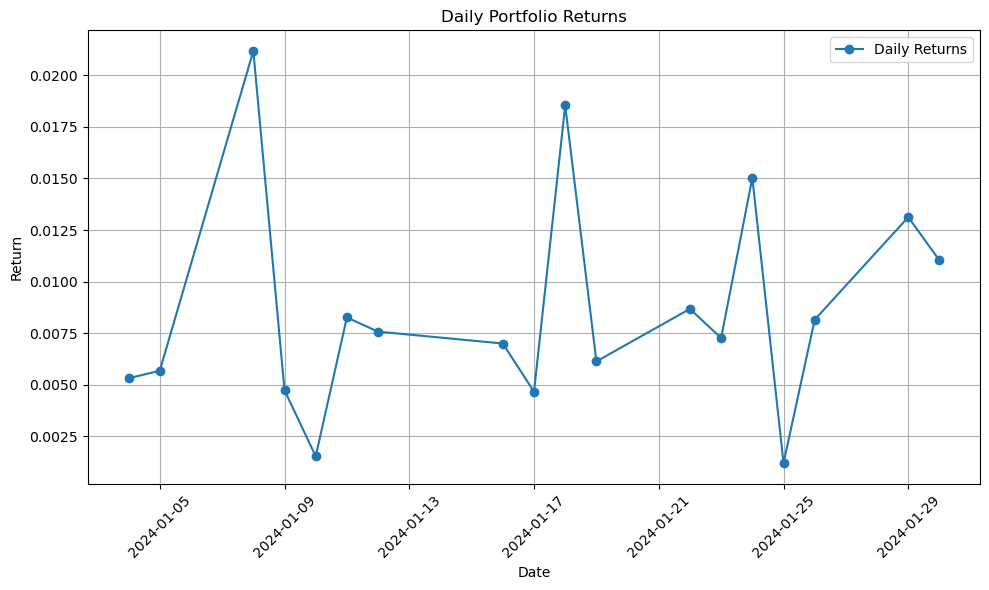

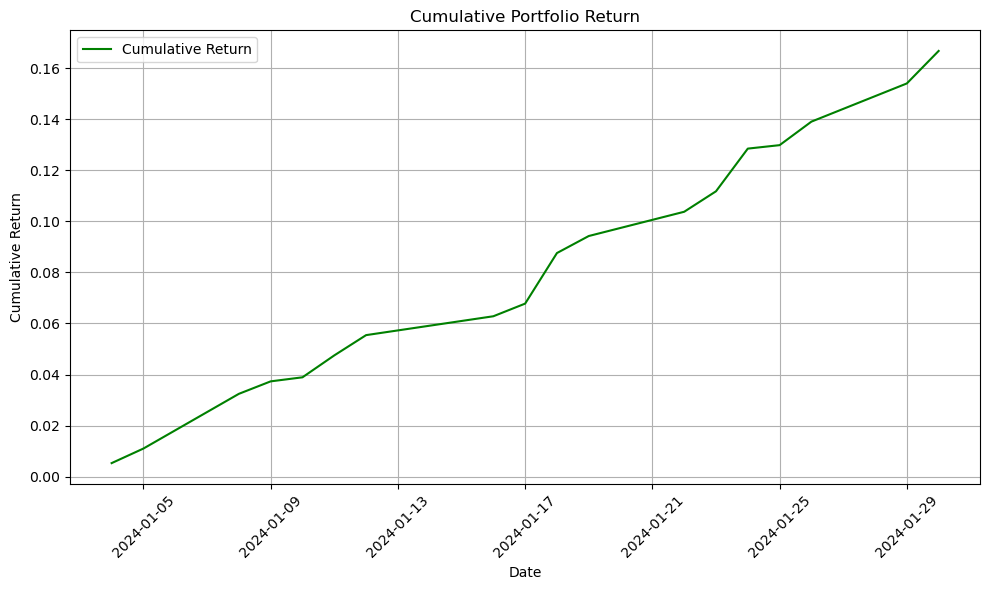

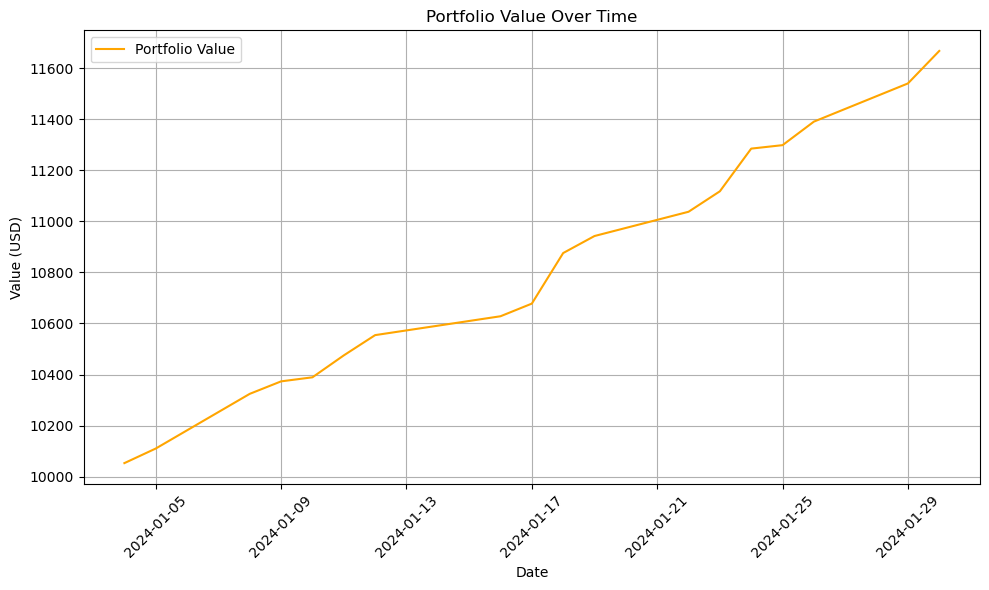

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

# Dados para o gráfico
portfolio_returns_df['Cumulative Return'] = (1 + portfolio_returns_df['Portfolio Return']).cumprod() - 1
portfolio_returns_df['Portfolio Value'] = initial_amount * ((1 + portfolio_returns_df['Portfolio Return']).cumprod())

# Gráfico 1: Retornos Diários
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['Date'], portfolio_returns_df['Portfolio Return'], marker='o', linestyle='-', label='Daily Returns')
plt.title('Daily Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 2: Retorno Acumulado
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['Date'], portfolio_returns_df['Cumulative Return'], color='green', label='Cumulative Return')
plt.title('Cumulative Portfolio Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 3: Valor do Portfólio
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['Date'], portfolio_returns_df['Portfolio Value'], color='orange', label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Partindo agora para a análise gráfica do portfólio:

- No gráfico `Daily Portfólio Returns` podemos verificar que apesar das oscilações, **não há retornos negativos significativos**, o que é um sinal positivo de estabilidade na estratégia de alocação. O **padrão** sugere que o portfólio **aproveita bem as oportunidades de retorno sem grandes flutuações**. 

- Podemos também observar que no gráfico `Cumulative Portfolio Return` a curva mostra um **crescimento consistente e estável** ao longo do tempo, **sem quedas abruptas**. O **crescimento acumulado** de 15,92% está bem representado pela inclinação constante da linha, refletindo uma estratégia **eficiente em gerar retornos ao longo do período**. O portfólio parece ter atingido um **bom equilíbrio entre risco e retorno**, mantendo a trajetória positiva mesmo com a variabilidade diária. 

- O gráfico `Portfolio Value Over Time` revela **pequenas inflexões** que sugerem que os retornos diários foram **bem acumulados** ao longo do tempo, mesmo considerando o custo operacional. Não há quedas significativas no valor, indicando que o portfólio é **resiliente e bem gerido**. 

Este desempenho é robusto e estável, ideal para um portfólio com foco em redução de risco e crescimento sustentável.

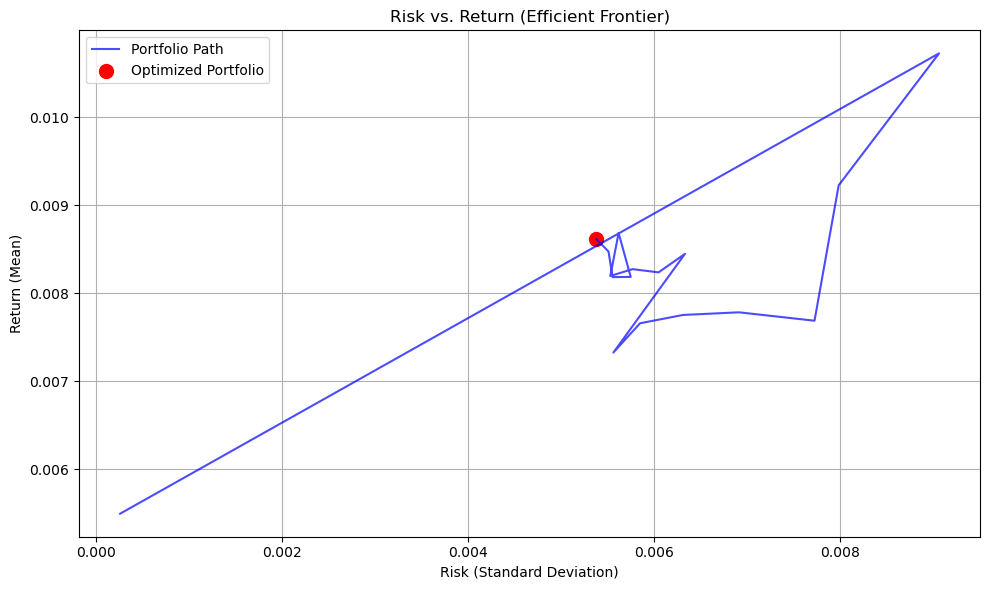

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Calculando risco (desvio padrão) e retorno (média) dos retornos diários
portfolio_returns_df['Risk'] = portfolio_returns_df['Portfolio Return'].expanding().std()
portfolio_returns_df['Mean Return'] = portfolio_returns_df['Portfolio Return'].expanding().mean()

# Ponto final: Risco e retorno do portfólio otimizado
final_risk = portfolio_returns_df['Risk'].iloc[-1]
final_return = portfolio_returns_df['Mean Return'].iloc[-1]

# Gráfico de Retorno x Risco
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['Risk'], portfolio_returns_df['Mean Return'], label='Portfolio Path', color='blue', alpha=0.7)
plt.scatter(final_risk, final_return, color='red', label='Optimized Portfolio', s=100)  # Ponto final
plt.title('Risk vs. Return (Efficient Frontier)')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Mean)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


O gráfico evidencia que o portfólio otimizado **atinge um equilíbrio ideal entre risco e retorno**, posicionando-se exatamente na **fronteira eficiente**. O caminho do portfólio (em azul) possui **alguma volatilidade**, mas ele **converge para um ponto próximo da fronteira**, mostrando que a alocação se ajustou bem ao longo do tempo. Este resultado é um excelente indicativo de sucesso na estratégia de otimização. O portfólio conseguiu atingir um retorno satisfatório com risco controlado, cumprindo o objetivo de maximização do retorno ajustado ao risco. 

# LSTM <a name = "lstm"> </a>
[[voltar ao índice]](#indice)

A utilização de Redes Neuronais Recorrentes (RNN), mais especificamente a variante LSTM (Long Short-Term Memory), é especialmente apropriada no contexto da previsão de retornos de portfólio, devido à natureza sequencial e temporal dos dados financeiros. O LSTM foi escolhido por sua capacidade de capturar padrões de longo prazo e gerenciar dependências temporais em séries temporais, algo que modelos tradicionais muitas vezes não conseguem fazer com a mesma eficácia.

## Treino do Modelo - LSTM <a name = "tm_lstm"> </a>
[[voltar a LSTM]](#lstm)

Este modelo utiliza um processo semelhante ao utilizado no Random Forest, contudo, apresenta algumas distinções, tais que o treino deste modelo vai ser realizado do seguinte modo:

- **Andar de tuplo em tuplo:** Isto tem como objetivo, tal como foi dito previamente, encontrar os padrões de empresas dentro do mesmo setor, o que nos permite prever melhor os resultados das empresas individualmente no futuro.

- **Normalização MinMax:** É aplicada uma normalização a todas as colunas numéricas, de modo a ssegurar que os valores ficam entre [0,1].

- **Dividir os Dados:** Quando vamos buscar os dados de Treino e Teste para cada setor, temos o cuidado de separar o X do Y, sendo que ao X, retiramos os valores do 'Close' e do 'Adj Close', para além de também tirarmos 'Symbol' e 'Name' por serem irreleantes, e para o Y damos apenas o valor do 'Close'.

- **Realizamos Time Steps no treino:** Transformamos os dados em sequências temporais (janelas) para alimentar a LSTM

- **Guardamos os modelos treinados:** Caso seja necessário utiliza-los futuramente

- **Testamos cada Empresa daquele setor no modelo treinado:** Criamos novamente sequencias temporais para o teste e de seguida obtemos os resultados e é necessário desnormalizar novamente os valores para que obtermos resultados mais próximos dos reais.

Configurar o número de time steps:

In [67]:
# Configuração do modelo
time_steps = 3 #Três dias para prever o close um 
metrics_by_sector = {}

Listas usadas para guardar valores relevantes:

In [68]:
all_sector_rmse = []
all_sector_mae = []
all_sector_mape = []
# Para armazenar retornos e métricas por empresa
company_metrics = []
all_predictions = []

Função auxiliar para dividir os dados:

In [69]:
def create_dataset_from_dataframe(dataframe, input_cols, target_col, time_steps):
    X, y = [], []
    data = dataframe[input_cols].values  # Entradas (X)
    target = dataframe[target_col].values  # Saída (y)

    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])  # Sequência de entrada
        y.append(target[i + time_steps])  # Valor alvo correspondente

    return np.array(X), np.array(y)

In [ ]:
param_grid = {
    'units1': [32,64],
    'dropout1': [0.1,0.2],
    'units2': [32,64],
    'dropout2': [0.1,0.2],
    'lr': [1e-3,1e-2]
}

Código para treinar e testar o modelo:

In [83]:
# Iterar sobre os setores
for sector, dataframe, test_dataframe in tqdm(sectors_list_lstm, desc="Processing sectors"):
    
    # NORMALIZAR OS DADOS DE TREINO
    # Preparar os dados de treino
    columns_to_scale = [col for col in dataframe.columns if col != 'Date' and col != 'Symbol' and col != 'Name']
    # Extrair os valores das colunas para normalização
    values_to_scale = dataframe[columns_to_scale].values  # Obter apenas os valores das colunas numéricas
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(values_to_scale)  # Normalizar as colunas
    # Atualizar o dataframe com os valores normalizados
    dataframe[columns_to_scale] = scaled_values
    

    #Passar a data para float 
    value_cols = [col for col in dataframe.columns if col != 'Date' and col != 'Symbol' and col != 'Name' and col != 'Close' and col != 'Adj Close']
    target_col = 'Close'  # Alvo é 'Close'
   

    X_train, y_train = create_dataset_from_dataframe(
        dataframe,  # DataFrame de treino
        input_cols = value_cols,  # Colunas de entrada
        target_col = target_col,  # Coluna alvo
        time_steps = time_steps  # Tamanho da janela temporal
    )

    model = LSTMModel(time_steps, input_shape=(time_steps, 18))
    
    best_params = model.tune_model(X_train,y_train, param_grid)

    
    model.train_best_model(X_train,y_train,best_params)
    
    # Salvar o modelo treinado (um arquivo por setor ou empresa)
    model_name = f"models_lstm/model_{sector}.pkl"
    dump(model, model_name)  # Salva o modelo no formato H5  # Salva o modelo no formato H5
    print(f"Modelo salvo: {model_name}")

    sector_rmse = []
    sector_mae = []
    sector_mape = []
    
    companies = dataframe['Symbol'].unique()
    
    
    # NORMALIZAR O TESTE (SEM O CLOSE)
    columns_to_scale = [col for col in test_dataframe.columns if col != 'Date' and col != 'Symbol' and col != 'Name' and col != 'Close'and col != 'Adj Close']
    # Extrair os valores das colunas para normalização
    values_to_scale = test_dataframe[columns_to_scale].values  # Obter apenas os valores das colunas numéricas
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(values_to_scale)  # Normalizar as colunas
    # Atualizar o dataframe com os valores normalizados
    test_dataframe[columns_to_scale] = scaled_values

    
    # NORMALIZAR APENAS O CLOSE NO TESTE
    print("Antes de normalizar")
    print(test_dataframe['Close'])
    # Ensure the 'Close' column is reshaped for fitting
    close_to_scale = test_dataframe['Close'].values.reshape(-1, 1)
    # Create and fit a MinMaxScaler specifically for 'Close'
    scaler_close = MinMaxScaler(feature_range=(0, 1))
    scaled_close_values = scaler_close.fit_transform(close_to_scale)
    # Update the 'Close' column with scaled values
    test_dataframe['Close'] = scaled_close_values
    print("Depois de normalizar")
    print(test_dataframe['Close'])


    for company in companies:
        company_data = test_dataframe[test_dataframe['Symbol'] == company]
        value_cols = [col for col in test_dataframe.columns if col != 'Date' and col != 'Symbol' and col != 'Name' and col != 'Close' and col != 'Adj Close']
        target_col = 'Close'  # Alvo é 'Close'
        
        X_teste, y_company = create_dataset_from_dataframe(
            company_data,  # DataFrame de treino
            input_cols = value_cols,  # Colunas de entrada
            target_col = target_col,  # Coluna alvo
            time_steps = time_steps  # Tamanho da janela temporal
        )
        
        #Prever
        y_pred = model.predict(X_teste)
       
        # Guardar os valores reais e previstos
        
        # Desnormalizar y_pred e y_company
        y_pred_denormalized = scaler_close.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_company_denormalized = scaler_close.inverse_transform(y_company.reshape(-1, 1)).flatten()
        
        rmse_company = np.sqrt(mean_squared_error(y_company_denormalized, y_pred_denormalized))
        mae_company = mean_absolute_error(y_company_denormalized, y_pred_denormalized)
        print("y_company_denormalized: ", y_company_denormalized)
       
        mape_company = np.mean(np.abs((y_company_denormalized - y_pred_denormalized) / (y_company_denormalized))) * 100
        
        # Ajustar o tamanho do DataFrame de origem para corresponder às previsões
        company_data = company_data.iloc[-len(y_pred):]  # Pega as últimas linhas para alinhar com y_pred

        # Atualizar os valores previstos e reais no DataFrame
        company_data['Predicted_Close'] = y_pred_denormalized
        company_data['True_Close'] = y_company_denormalized
        company_data['Predicted_Return'] = company_data['Predicted_Close'].pct_change()
        company_data['Sector'] = sector
        company_data['Company'] = company
        
        all_predictions.append(company_data)

        # Store daily return metrics
        mean_predicted_return = company_data['Predicted_Return'].mean()
        std_predicted_return = company_data['Predicted_Return'].std()
        sharpe_ratio = mean_predicted_return / std_predicted_return if std_predicted_return != 0 else 0

        # Append to company metrics list
        company_metrics.append({
            'Sector': sector,
            'Company': company,
            'RMSE': rmse_company,
            'MAE': mae_company,
            'MAPE': mape_company,
            'Mean_Return': mean_predicted_return,
            'Std_Return': std_predicted_return,
            'Sharpe_Ratio': sharpe_ratio
        })
        sector_rmse.append(rmse_company)
        sector_mae.append(mae_company)
        sector_mape.append(mape_company)
        
        print(f"Company: {company}")
        print(f"RMSE: {rmse_company:.3f}")
        print(f"MAE: {mae_company:.3f}")
        print(f"MAPE: {mape_company:.3f}%")
        
    mean_sector_rmse = np.mean(sector_rmse)
    mean_sector_mae = np.mean(sector_mae)
    mean_sector_mape = np.mean(sector_mape)

    print(f"Mean RMSE for sector {sector}: {mean_sector_rmse:.3f}")
    print(f"Mean MAE for sector {sector}: {mean_sector_mae:.3f}")
    print(f"Mean MAPE for sector {sector}: {mean_sector_mape:.3f}%")
        
    all_sector_rmse.append(mean_sector_rmse)
    all_sector_mae.append(mean_sector_mae)
    all_sector_mape.append(mean_sector_mape)

Processing sectors:   0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Basic Materials.pkl
Antes de normalizar
0      146.889999
1      140.179993
2      135.929993
3      135.830002
4      136.580002
          ...    
435    219.800003
436    223.410004
437    222.360001
438    229.369995
439    231.050003
Name: Close, Length: 440, dtype: float64
Depois de normalizar
0      0.237240
1      0.223430
2      0.214683
3      0.214477
4      0.216020
         ...   
435    0.387297
436    0.394727
437    0.392566
438    0.406993
439    0.410451
Name: Close, Length: 440, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
y_company_denormalized:  [135.83000183 136.58000183 133.66999817 132.94000244 128.6499939
 126.05000305 125.94999695 120.69999695 117.98999786 115.12999725
 120.75       122.58999634 121.69000244 118.44999695 119.83999634
 123.19999695 120.30999756]
Company: ALB
RMSE: 10.996
MAE: 10.453
MAPE: 8.436%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
y_company_denormalized:  [270.1499939  272.83999634 268.08999634 266.9599

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Communication Services.pkl
Antes de normalizar
0      391.510010
1      386.670013
2      375.750000
3      372.200012
4      378.869995
          ...    
435     10.410000
436     10.580000
437     10.620000
438     10.490000
439     10.100000
Name: Close, Length: 440, dtype: float64
Depois de normalizar
0      0.674239
1      0.665683
2      0.646379
3      0.640103
4      0.651894
         ...   
435    0.000548
436    0.000849
437    0.000919
438    0.000689
439    0.000000
Name: Close, Length: 440, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
y_company_denormalized:  [372.20001221 378.86999512 368.60998535 367.         367.61999512
 364.8999939  368.33999634 359.23999023 364.54998779 371.1000061
 373.1499939  378.64001465 371.39001465 369.07000732 377.07000732
 380.82998657 376.98001099]
Company: CHTR
RMSE: 14.129
MAE: 12.349
MAPE: 3.321%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
y_company_denormalized:  [43.04000092 43.72999954 43.27999878 43.

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Consumer Cyclical.pkl
Antes de normalizar
0       134.479996
1       133.419998
2       133.720001
3       135.979996
4       140.080002
           ...    
1075    129.440002
1076    130.220001
1077    129.089996
1078    130.550003
1079    130.619995
Name: Close, Length: 1080, dtype: float64
Depois de normalizar
0       0.016900
1       0.016756
2       0.016797
3       0.017102
4       0.017656
          ...   
1075    0.016219
1076    0.016324
1077    0.016172
1078    0.016369
1079    0.016378
Name: Close, Length: 1080, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
y_company_denormalized:  [135.97999573 140.08000183 139.52999878 139.75999451 139.44999695
 137.13999939 135.02000427 134.97999573 137.03999329 139.92999268
 142.00999451 142.30000305 141.19000244 142.11000061 149.61999512
 152.69999695 149.44000244]
Company: ABNB
RMSE: 106.336
MAE: 106.303
MAPE: 75.458%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
y_company_denormalized:  [9.73999977 9.810

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Consumer Defensive.pkl
Antes de normalizar
0      72.760002
1      73.129997
2      71.750000
3      70.809998
4      71.059998
         ...    
735    53.500000
736    54.279999
737    54.756668
738    55.013332
739    55.196667
Name: Close, Length: 740, dtype: float64
Depois de normalizar
0      0.076921
1      0.077465
2      0.075436
3      0.074054
4      0.074422
         ...   
735    0.048610
736    0.049757
737    0.050457
738    0.050835
739    0.051104
Name: Close, Length: 740, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
y_company_denormalized:  [70.80999756 71.05999756 70.66999817 69.33000183 69.47000122 69.55999756
 69.09999847 68.91999817 68.73999786 68.19000244 51.68999863 52.31000137
 52.63000107 51.38000107 52.04999924 54.93999863 56.        ]
Company: ADM
RMSE: 9.965
MAE: 7.515
MAPE: 13.570%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
y_company_denormalized:  [55.09000015 55.68999863 55.56000137 55.59000015 55.50999832 55.77999878
 

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Energy.pkl
Antes de normalizar
0       36.110001
1       36.750000
2       34.049999
3       34.340000
4       33.730000
          ...    
435     99.599998
436    102.129997
437    103.000000
438    103.129997
439    104.849998
Name: Close, Length: 440, dtype: float64
Depois de normalizar
0      0.125621
1      0.129804
2      0.112157
3      0.114052
4      0.110065
         ...   
435    0.540588
436    0.557124
437    0.562810
438    0.563660
439    0.574902
Name: Close, Length: 440, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
y_company_denormalized:  [34.34000015 33.72999954 32.97000122 32.56999969 32.45999908 32.54000092
 31.27000046 30.80999947 30.68000031 30.37000084 30.70999908 30.85000038
 31.37000084 32.04000092 32.11000061 31.87000084 32.41999817]
Company: APA
RMSE: 1.113
MAE: 0.964
MAPE: 3.018%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
y_company_denormalized:  [33.41999817 32.43999863 31.62000084 31.22999954 31.17000008 31.52000046
 30

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Financial Services.pkl
Antes de normalizar
0        75.550003
1        76.940002
2        77.470001
3        76.809998
4        77.120003
           ...    
1335    250.990005
1336    250.720001
1337    249.479996
1338    246.440002
1339    247.779999
Name: Close, Length: 1340, dtype: float64
Depois de normalizar
0       0.079816
1       0.081568
2       0.082237
3       0.081404
4       0.081795
          ...   
1335    0.300996
1336    0.300656
1337    0.299092
1338    0.295260
1339    0.296949
Name: Close, Length: 1340, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
y_company_denormalized:  [76.80999756 77.12000275 76.15000153 76.95999908 77.62000275 77.69000244
 78.16999817 78.66999817 78.95999908 80.87999725 80.47000122 80.33999634
 80.12999725 79.59999847 79.90000153 79.73000336 80.58000183]
Company: ACGL
RMSE: 4.515
MAE: 4.437
MAPE: 5.642%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
y_company_denormalized:  [82.72000122 82.87000275 80.55000305 82

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Healthcare.pkl
Antes de normalizar
0       138.750000
1       131.160004
2       131.000000
3       130.559998
4       133.380005
           ...    
1235    186.070007
1236    187.320007
1237    191.520004
1238    192.759995
1239    191.429993
Name: Close, Length: 1240, dtype: float64
Depois de normalizar
0       0.103961
1       0.097771
2       0.097641
3       0.097282
4       0.099582
          ...   
1235    0.142551
1236    0.143570
1237    0.146995
1238    0.148006
1239    0.146922
Name: Close, Length: 1240, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
y_company_denormalized:  [130.55999756 133.38000488 130.67999268 131.08999634 129.67999268
 130.53999329 130.52999878 128.11999512 130.46000671 131.22000122
 132.55000305 131.63999939 129.77999878 129.88000488 130.99000549
 132.83000183 134.27999878]
Company: A
RMSE: 5.278
MAE: 5.084
MAPE: 3.887%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
y_company_denormalized:  [162.13999939 161.42999268 162.3

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Industrials.pkl
Antes de normalizar
0       124.250000
1       121.510002
2       122.269997
3       122.779999
4       123.730003
           ...    
1375    111.699997
1376    112.980003
1377    112.389999
1378    113.360001
1379    113.750000
Name: Close, Length: 1380, dtype: float64
Depois de normalizar
0       0.091571
1       0.088983
2       0.089701
3       0.090183
4       0.091080
          ...   
1375    0.079716
1376    0.080925
1377    0.080368
1378    0.081284
1379    0.081653
Name: Close, Length: 1380, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
y_company_denormalized:  [122.77999878 123.73000336 124.05000305 122.09999847 120.66999817
 119.77999878 119.41000366 118.72000122 121.16999817 122.19000244
 125.38999939 124.33000183 122.93000031 125.76000214 124.87000275
 126.86000061 126.19000244]
Company: ALLE
RMSE: 7.849
MAE: 7.591
MAPE: 6.175%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
y_company_denormalized:  [160.74000549 161.88000488 1

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Real Estate.pkl
Antes de normalizar
0      218.809998
1      214.690002
2      215.460007
3      214.279999
4      216.080002
          ...    
615     33.130001
616     33.320000
617     33.110001
618     32.990002
619     33.090000
Name: Close, Length: 620, dtype: float64
Depois de normalizar
0      0.243256
1      0.238250
2      0.239185
3      0.237752
4      0.239939
         ...   
615    0.017631
616    0.017862
617    0.017607
618    0.017461
619    0.017583
Name: Close, Length: 620, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
y_company_denormalized:  [214.27999878 216.08000183 211.86000061 208.97000122 207.6499939
 209.42999268 208.05000305 204.94999695 203.91000366 203.86999512
 204.02000427 202.25999451 196.75999451 200.21000671 197.28999329
 199.11000061 195.55999756]
Company: AMT
RMSE: 31.236
MAE: 30.619
MAPE: 15.009%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
y_company_denormalized:  [126.51000214 129.75       128.33999634 129.1300048

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Technology.pkl
Antes de normalizar
0       185.639999
1       184.250000
2       181.910004
3       181.179993
4       185.559998
           ...    
1635    254.169998
1636    256.989990
1637    252.169998
1638    255.929993
1639    250.910004
Name: Close, Length: 1640, dtype: float64
Depois de normalizar
0       0.134039
1       0.132947
2       0.131110
3       0.130537
4       0.133976
          ...   
1635    0.187857
1636    0.190072
1637    0.186287
1638    0.189239
1639    0.185297
Name: Close, Length: 1640, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
y_company_denormalized:  [181.17999268 185.55999756 185.13999939 186.19000244 185.58999634
 185.91999817 183.63000488 182.67999268 188.63000488 191.55999756
 193.88999939 195.17999268 194.5        194.16999817 192.41999817
 191.72999573 188.03999329]
Company: AAPL
RMSE: 23.219
MAE: 22.389
MAPE: 11.850%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
y_company_denormalized:  [336.61999512 340.3500061 

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo salvo: models_lstm/model_Utilities.pkl
Antes de normalizar
0      74.000000
1      73.669998
2      73.910004
3      74.050003
4      74.660004
         ...    
615    58.220001
616    58.889999
617    59.389999
618    59.660000
619    59.759998
Name: Close, Length: 620, dtype: float64
Depois de normalizar
0      0.490949
1      0.488132
2      0.490181
3      0.491376
4      0.496585
         ...   
615    0.356216
616    0.361936
617    0.366206
618    0.368511
619    0.369365
Name: Close, Length: 620, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
y_company_denormalized:  [74.05000305 74.66000366 74.01999664 73.77999878 72.19999695 71.88999939
 71.20999908 70.31999969 69.61000061 69.27999878 68.84999847 69.01999664
 68.36000061 69.68000031 69.51000214 69.79000092 70.02999878]
Company: AEE
RMSE: 6.491
MAE: 6.329
MAPE: 8.969%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
y_company_denormalized:  [84.06999969 84.51000214 84.12999725 82.54000092 80.40000153 81.48999786
 80.9800033

Guardar as previsões:

In [84]:
# Combinar todas as previsões em um único DataFrame
final_predictions_lstm= pd.concat(all_predictions, ignore_index=True)
# Salvar os resultados em CSV para análise posterior (opcional)
final_predictions_lstm.to_csv("predicted_close_and_returns_lstm.csv", index=False)

Visualização das métricas finais:

In [85]:
overall_rmse = np.mean(all_sector_rmse)
overall_mae = np.mean(all_sector_mae)
overall_mape = np.mean(all_sector_mape)
print("\n--- Overall Model Performance ---")
print(f"Overall Mean RMSE: {overall_rmse:.3f}")
print(f"Overall Mean MAE: {overall_mae:.3f}")
print(f"Overall Mean MAPE: {overall_mape:.3f}%")


--- Overall Model Performance ---
Overall Mean RMSE: 20.512
Overall Mean MAE: 19.924
Overall Mean MAPE: 25.314%


Como podemos ver as metricas obtidas a partir da lstm são satisfatórias, nomeadamente o RMSE e MAE penalizam grandes erros. 

Seleção dos melhores Portfolios:

In [86]:
# Convert company metrics to DataFrame
company_metrics_df = pd.DataFrame(company_metrics)
# Select top companies for portfolio
top_companies = company_metrics_df.sort_values(by='Sharpe_Ratio', ascending=False).head(10)
print("\n--- Top Companies for Portfolio ---")
print(top_companies[['Company', 'Sector', 'Mean_Return', 'Sharpe_Ratio']])


--- Top Companies for Portfolio ---
    Company              Sector  Mean_Return  Sharpe_Ratio
343     TDG         Industrials     0.006384      1.114105
312     GWW         Industrials     0.006242      0.941379
213    SPGI  Financial Services     0.004376      0.803801
394     AMD          Technology     0.015106      0.800705
240    CTLT          Healthcare     0.010666      0.785509
446    PANW          Technology     0.015823      0.774347
440     NOW          Technology     0.015808      0.711149
105    COST  Consumer Defensive     0.004647      0.688269
398    AVGO          Technology     0.007871      0.639767
349     URI         Industrials     0.012919      0.633572


## Criação e otimização do portfolio - LSTM <a name = "p_lstm"> </a>
[[voltar a LSTM]](#lstm)

A criação do portfólio para o LSTM será realizada exatamente da mesma forma, com exceção de haver a necessidade de agrupar as colunas 'Ano, 'Mês' e 'Dia', uma vez que para este modelo elas não existem. Assim sendo passamos então para a criação do portfólio, começando por combinar os retornos diários:

In [97]:
final_predictions_lstm = pd.read_csv("predicted_close_and_returns_lstm.csv")

In [98]:
# Combinar os retornos diários previstos por empresa
combined_returns_lstm = final_predictions_lstm.pivot(index='Date', columns='Company', values='Predicted_Return')
# Verificar o resultado
print(combined_returns)

Company            A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2024-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
2024-01-08  0.001049 -0.002084 -0.003688  0.004824 -0.003260 -0.000028   
2024-01-09  0.016061  0.032247  0.001289  0.036004  0.003642  0.001367   
2024-01-10 -0.011786 -0.014725  0.004669 -0.031979  0.005386 -0.013638   
2024-01-11 -0.002295 -0.007447  0.004784 -0.007838  0.008582  0.002810   
2024-01-12 -0.011202  0.006799  0.005874  0.004065 -0.002410  0.015052   
2024-01-16  0.003280  0.017898  0.003434 -0.018605  0.005727  0.005346   
2024-01-17  0.002910 -0.013382 -0.012218 -0.004530  0.001882  0.003049   
2024-01-18 -0.009130 -0.024721 -0.002505  0.019512  0.002786  0.000286   
2024-01-19  0.010711  0.046297  0.002001  0.002877  0.002236  0.000770   
2024-01-22  0.007833  0.031189  0.004275  0.018444  0.000333  0.010825   
2024-01-23  0.007999  0.008225  0.0091

Como sabemos vamos utilizar o Monte Carlo, e, apesar de a informação ser repetida, iremos novamente aqui colocá-la para sabermos exatamente o que está a ser feito:

- **Soma dos Pesos Igual a 1:** Os pesos atribuídos aos ativos devem somar 1, garantindo que o portfólio representa uma alocação completa de capital.

- **Limite de Volume Diário (100 ações):** O portfólio não pode ultrapassar um total de 100 ações compradas por dia, distribuídas entre os ativos.

- **Interrupção ao Alcançar o Limite:** Assim que o volume total de ações compradas atinge 100, as compras adicionais são interrompidas para respeitar a restrição.

- **Custo Operacional Diário:** É subtraído 1 USD do saldo total a cada dia para contabilizar custos de operação.

- **Vaçor inicial de 10.000 USD:** O saldo inicial do portfólio é limitado a 10.000 USD, condicionando a capacidade de alocação de recursos.

- **Capacidade de Compra Baseada no Saldo Atual:** A alocação para cada ativo é limitada pelo saldo disponível no momento, garantindo que as decisões de investimento sejam realistas

- **Rastreamento do Volume Total:** Uma variável *total_volume* é usada para monitorizar continuamente o número total de ações compradas em cada dia.

- **Ajuste de Pesos com Base no Volume:** Caso o volume total de ações exceda o limite de 100, os pesos dos ativos são ajustados proporcionalmente para cumprir a restrição.

- **Normalização dos Pesos Após Ajustes:** Após o ajuste de pesos, eles são renormalizados para garantir que somem 1 e a alocação permaneça proporcional.

In [99]:
def portfolio_daily_return(weights, daily_returns):
    return np.dot(weights, daily_returns)

In [100]:
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

In [101]:
def objective_function(weights, daily_returns, cov_matrix, lambda_=0.5):
    daily_ret = portfolio_daily_return(weights, daily_returns)
    risk = portfolio_risk(weights, cov_matrix)
    return lambda_ * daily_ret - (1 - lambda_) * risk

In [102]:
def monte_carlo_daily_optimization(daily_returns, cov_matrix, lambda_=0.5, iterations=1000):
    best_weights = None
    best_objective = -np.inf

    for _ in range(iterations):
        # Gerar pesos aleatórios que somam 1
        weights = dirichlet(np.ones(len(daily_returns)))
        objective = objective_function(weights, daily_returns, cov_matrix, lambda_)

        if objective > best_objective:
            best_objective = objective
            best_weights = weights

    return best_weights

In [103]:
# Inicializar valores
initial_amount = 10000  # Saldo inicial em USD
operation_cost = 1  # Custo operacional diário
max_total_volume = 100  # Máximo de ações no total por dia
current_balance = initial_amount  # Saldo inicial
weights_history = []  # Pesos ótimos ao longo do tempo
portfolio_returns_daily = []  # Retornos diários ajustados

In [104]:
i = 0
for day in combined_returns_lstm.index:
    if i == 0 or i == 1:
        i += 1
        continue

    # Obter retornos até o dia atual
    historical_returns = combined_returns_lstm.loc[:day]
    historical_returns = historical_returns.dropna(how="any", axis=0)  # Remover NaNs

    # Calcular média e matriz de covariância
    daily_mean_returns = historical_returns.mean().values
    daily_cov_matrix = historical_returns.cov().values

    # Otimização Monte Carlo para determinar os pesos
    best_weights = monte_carlo_daily_optimization(daily_mean_returns, daily_cov_matrix, lambda_=0.5, iterations=100000)
    best_weights = np.array(best_weights).flatten()

    weights_history.append(best_weights)

    # Calcular valor alocado para cada empresa
    daily_returns = combined_returns_lstm.loc[day].values
    daily_stock_values = best_weights * current_balance  # Valor alocado para cada empresa

    # Ajustar pesos para respeitar o limite total de 100 ações
    adjusted_weights = np.zeros_like(best_weights)
    total_volume = 0
    for idx, value in enumerate(daily_stock_values):
        # Calcular o número de ações possível para este peso
        stock_price = daily_returns[idx]
        if stock_price > 0:
            num_shares = value / stock_price  # Número de ações
            if total_volume + num_shares > max_total_volume:
                num_shares = max_total_volume - total_volume  # Limitar para não ultrapassar o máximo
            adjusted_value = num_shares * stock_price  # Valor ajustado
            adjusted_weights[idx] = adjusted_value / current_balance if current_balance > 0 else 0
            total_volume += num_shares  # Atualizar o total de ações compradas

        # Interromper se já atingimos o limite total de 100 ações
        if total_volume >= max_total_volume:
            break

    # Normalizar pesos ajustados
    if adjusted_weights.sum() > 0:
        adjusted_weights /= adjusted_weights.sum()

    # Calcular retorno diário do portfólio
    daily_return_portfolio = np.dot(adjusted_weights, daily_returns)
    portfolio_returns_daily.append(daily_return_portfolio)

    # Atualizar saldo com retorno diário e subtrair custo operacional
    current_balance *= (1 + daily_return_portfolio)
    current_balance -= operation_cost  # Subtrair custo operacional

    i += 1

# Calcular o retorno acumulado final
cumulative_return = calculate_cumulative_return(portfolio_returns_daily)
print(f"Retorno Acumulado Final do Portfólio: {cumulative_return:.4f}")
print("Preço final:", current_balance)

# Criar uma lista de datas correspondentes aos retornos calculados
dates_for_returns = combined_returns_lstm.index[2:]  # Ignorar os primeiros dois dias

# Criar DataFrame com os retornos diários do portfólio
portfolio_returns_df = pd.DataFrame({
    'Date': dates_for_returns,
    'Portfolio Return': portfolio_returns_daily
})

# Exibir DataFrame
print("\n--- Retornos Diários do Portfólio ---")
print(portfolio_returns_df.tail())

# Salvar os resultados em um arquivo CSV
portfolio_returns_df.to_csv('portfolio_returns_daily_lstm.csv', index=False)

Retorno Acumulado Final do Portfólio: 0.1596
Preço final: 11579.606548740632

--- Retornos Diários do Portfólio ---
          Date  Portfolio Return
10  2024-01-24          0.023024
11  2024-01-25          0.000517
12  2024-01-26          0.014923
13  2024-01-29          0.010070
14  2024-01-30          0.016006


**Análise dos resultados:**

Os resultados mostram que o portfólio obteve um Retorno Acumulado Final de 15,96% ao longo do mês, com um saldo final de 11,579.60, partindo de um capital inicial de 10,000. Isso indica um crescimento moderado do portfólio. Os retornos diários apresentados são consistentes e relativamente baixos. Eles variam entre 0,05% e 2,30% nos dias aqui apresentados. A consistência nos retornos diários sugere que a estratégia está a evitar perdas significativas e a entregar resultados estáveis, o que é desejável para muitos investidores. Esta estratégia é lucrativa e não apresenta grande volatilidade nos retornos diários. Os retornos são ajustados ao risco (via otimização), sugerindo que o portfólio é eficiente no trade-off entre retorno e risco.

**Análise Gráfica dos resultados:** 

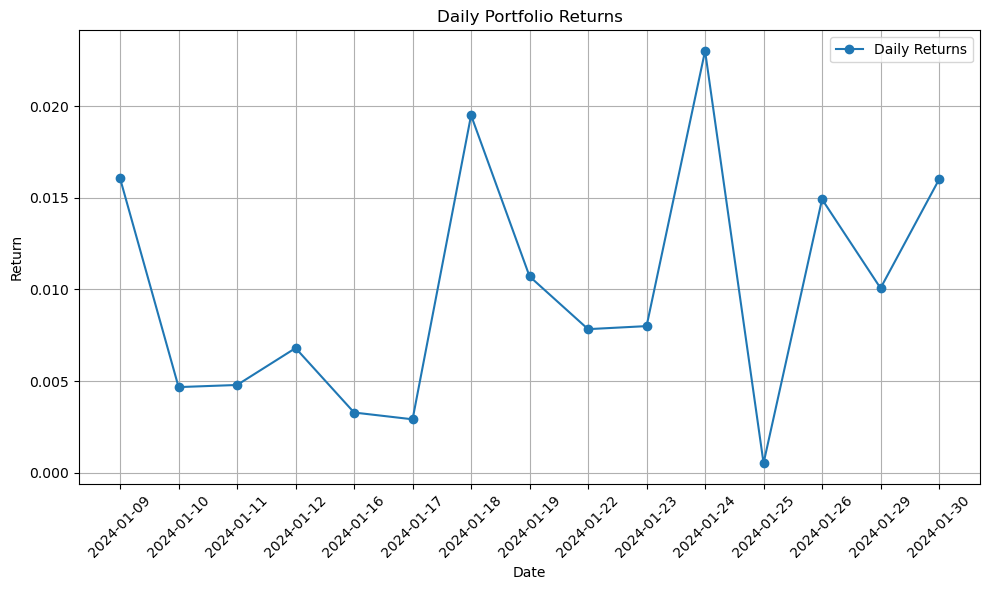

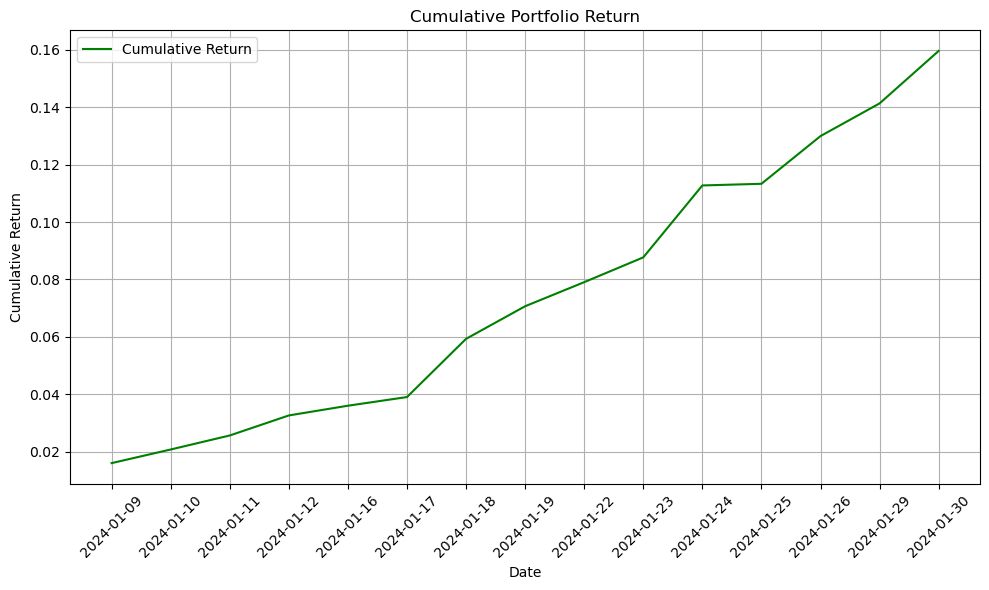

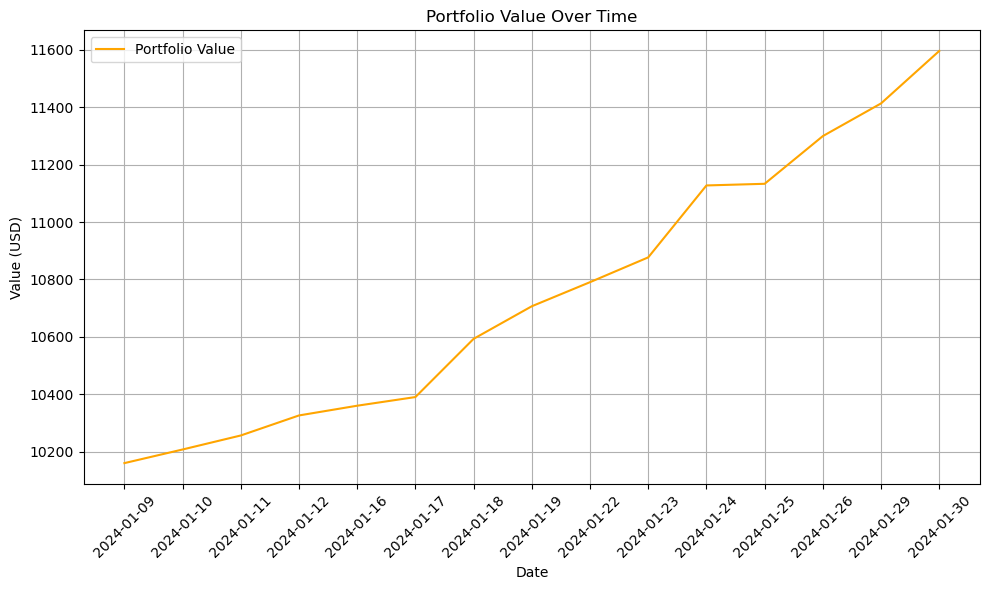

In [105]:
# Dados para o gráfico
portfolio_returns_df['Cumulative Return'] = (1 + portfolio_returns_df['Portfolio Return']).cumprod() - 1
portfolio_returns_df['Portfolio Value'] = initial_amount * ((1 + portfolio_returns_df['Portfolio Return']).cumprod())

# Gráfico 1: Retornos Diários
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['Date'], portfolio_returns_df['Portfolio Return'], marker='o', linestyle='-', label='Daily Returns')
plt.title('Daily Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 2: Retorno Acumulado
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['Date'], portfolio_returns_df['Cumulative Return'], color='green', label='Cumulative Return')
plt.title('Cumulative Portfolio Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 3: Valor do Portfólio
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['Date'], portfolio_returns_df['Portfolio Value'], color='orange', label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Os gráficos fornecem uma visão clara do desempenho do portfólio e complementam as métricas apresentadas. 

O gráfico `Daily Portfólio Returns` mostra que os retornos diários apresentam certa variabilidade, com picos como 2,23% num dia e retornos próximos de zero em outros. Essa flutuação indica que, embora o portfólio tenha retornos consistentes em geral, ele é sensível a variações diárias do mercado, algo esperado em estratégias de otimização baseadas em retornos.

Já o `Cumulative Portfolio Return` apresenta uma linha ascendente que reflete que o portfólio foi lucrativo ao longo do período analisado, sem quedas significativas, o que é um sinal positivo de estabilidade e boa gestão de risco.

Por fim, conseguimos ver no último grafico `Portfolio Over Time` que a tendência é de crescimento linear com pequenas inflexões, o que reflete os retornos diários acumulados após os ajustes de custo operacional.

Em conclusão, os resultados são positivos e indicam uma boa performance do modelo, com um equilíbrio entre retorno e risco. A ausência de quedas acentuadas nos gráficos de retorno acumulado e valor do portfólio sugere que o portfólio está bem diversificado e possui uma gestão de risco eficaz. Os picos nos retornos diários indicam algumas oportunidades de alto ganho, que foram bem aproveitadas e apesar do custo diário, o portfólio conseguiu crescer, o que demonstra que a estratégia é robusta o suficiente para superar despesas operacionais.

# Comparação de Resultados  <a name = "cr"> </a>
[[voltar ao índice]](#indice)

Agora, vamos comparar os resultados das previsões dos modelos LSTM e RandomForest com os resultados reais otimizados pelo Monte Carlo. 


## Criação do portfolio real  <a name = "p_cr"> </a>
[[voltar a Comparação de Resultados]](#cr)

Comparar os portfólios criados com o portfólio real é essencial para avaliar a eficácia e a relevância prática dos modelos desenvolvidos. Essa comparação permite validar a precisão das previsões de preços das ações, verificando se os métodos de machine learning conseguem captar corretamente o comportamento do mercado. 

Ao identificar discrepâncias entre os portfólios simulados e o real, é possível detectar limitações nos modelos ou nos pressupostos usados, promovendo melhorias contínuas. Esta análise também ajuda a compreender melhor os riscos associados, incluindo eventos inesperados que podem impactar significativamente o desempenho. Por fim, garante que os resultados obtidos sejam aplicáveis no contexto financeiro real, demonstrando o impacto e a utilidade prática das soluções propostas.

Deste modo, passamos à criação do portfólio real:

In [106]:
df_real = pd.read_csv("sorted_data.csv")

In [107]:
training_data = df_real[df_real['Date'] < '2024-01-01']  # Dados de treino: até dezembro de 2023
january_2024_data = df_real[(df_real['Date'] >= '2024-01-01') & (df_real['Date'] < '2024-02-01')]  # Dados de teste: janeiro df_real

In [108]:
january_2024_data['True_Return'] = january_2024_data['Close'].pct_change()
print(january_2024_data)

               Date       Close   Adj Close        High         Low  \
3503     2024-01-02  138.750000  138.048569  140.589996  137.910004   
3504     2024-01-03  131.160004  130.496948  138.000000  131.070007   
3505     2024-01-04  131.000000  130.337753  131.500000  130.190002   
3506     2024-01-05  130.559998  129.899994  131.960007  128.619995   
3507     2024-01-08  133.380005  132.705734  133.570007  129.809998   
...             ...         ...         ...         ...         ...   
1670355  2024-01-24  186.070007  184.663086  189.699997  185.929993   
1670356  2024-01-25  187.320007  185.903656  187.529999  185.309998   
1670357  2024-01-26  191.520004  190.071884  192.880005  188.970001   
1670358  2024-01-29  192.759995  191.302505  193.000000  189.960007   
1670359  2024-01-30  191.429993  189.982544  193.509995  190.440002   

               Open   Volume Symbol                  Name      SMA_10  ...  \
3503     138.190002  1441600      A  Agilent Technologies  139.119000

C:\Users\User\AppData\Local\Temp\ipykernel_33656\2542215601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  january_2024_data['True_Return'] = january_2024_data['Close'].pct_change()


In [109]:
# Combinar os retornos diários previstos por empresa
combined_returns_reais = january_2024_data.pivot(index='Date', columns='Symbol', values='True_Return')
# Verificar o resultado
print(combined_returns_reais)

Company            A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2024-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
2024-01-08  0.001049 -0.002084 -0.003688  0.004824 -0.003260 -0.000028   
2024-01-09  0.016061  0.032247  0.001289  0.036004  0.003642  0.001367   
2024-01-10 -0.011786 -0.014725  0.004669 -0.031979  0.005386 -0.013638   
2024-01-11 -0.002295 -0.007447  0.004784 -0.007838  0.008582  0.002810   
2024-01-12 -0.011202  0.006799  0.005874  0.004065 -0.002410  0.015052   
2024-01-16  0.003280  0.017898  0.003434 -0.018605  0.005727  0.005346   
2024-01-17  0.002910 -0.013382 -0.012218 -0.004530  0.001882  0.003049   
2024-01-18 -0.009130 -0.024721 -0.002505  0.019512  0.002786  0.000286   
2024-01-19  0.010711  0.046297  0.002001  0.002877  0.002236  0.000770   
2024-01-22  0.007833  0.031189  0.004275  0.018444  0.000333  0.010825   
2024-01-23  0.007999  0.008225  0.0091

In [110]:
# Inicializar valores
initial_amount = 10000  # Saldo inicial em USD
operation_cost = 1  # Custo operacional diário
max_total_volume = 100  # Máximo de ações no total por dia
current_balance = initial_amount  # Saldo inicial
weights_history = []  # Pesos ótimos ao longo do tempo
portfolio_returns_daily = []  # Retornos diários ajustados

i = 0
for day in combined_returns_reais.index:
    if i == 0 or i == 1:
        i += 1
        continue

    # Obter retornos até o dia atual
    historical_returns = combined_returns_reais.loc[:day]
    historical_returns = historical_returns.dropna(how="any", axis=0)  # Remover NaNs

    # Calcular média e matriz de covariância
    daily_mean_returns = historical_returns.mean().values
    daily_cov_matrix = historical_returns.cov().values

    # Otimização Monte Carlo para determinar os pesos
    best_weights = monte_carlo_daily_optimization(daily_mean_returns, daily_cov_matrix, lambda_=0.5, iterations=100000)
    best_weights = np.array(best_weights).flatten()

    weights_history.append(best_weights)

    # Calcular valor alocado para cada empresa
    daily_returns = combined_returns_reais.loc[day].values
    daily_stock_values = best_weights * current_balance  # Valor alocado para cada empresa

    # Ajustar pesos para respeitar o limite total de 100 ações
    adjusted_weights = np.zeros_like(best_weights)
    total_volume = 0
    for idx, value in enumerate(daily_stock_values):
        # Calcular o número de ações possível para este peso
        stock_price = daily_returns[idx]
        if stock_price > 0:
            num_shares = value / stock_price  # Número de ações
            if total_volume + num_shares > max_total_volume:
                num_shares = max_total_volume - total_volume  # Limitar para não ultrapassar o máximo
            adjusted_value = num_shares * stock_price  # Valor ajustado
            adjusted_weights[idx] = adjusted_value / current_balance if current_balance > 0 else 0
            total_volume += num_shares  # Atualizar o total de ações compradas

        # Interromper se já atingimos o limite total de 100 ações
        if total_volume >= max_total_volume:
            break

    # Normalizar pesos ajustados
    if adjusted_weights.sum() > 0:
        adjusted_weights /= adjusted_weights.sum()

    # Calcular retorno diário do portfólio
    daily_return_portfolio = np.dot(adjusted_weights, daily_returns)
    portfolio_returns_daily.append(daily_return_portfolio)

    # Atualizar saldo com retorno diário e subtrair custo operacional
    current_balance *= (1 + daily_return_portfolio)
    current_balance -= operation_cost  # Subtrair custo operacional

    i += 1

# Calcular o retorno acumulado final
cumulative_return = calculate_cumulative_return(portfolio_returns_daily)
print(f"Retorno Acumulado Final do Portfólio: {cumulative_return:.4f}")
print("Preço final:", current_balance)

# Criar uma lista de datas correspondentes aos retornos calculados
dates_for_returns = combined_returns_reais.index[2:]  # Ignorar os primeiros dois dias

# Criar DataFrame com os retornos diários do portfólio
portfolio_returns_df = pd.DataFrame({
    'Date': dates_for_returns,
    'Portfolio Return': portfolio_returns_daily
})

# Exibir DataFrame
print("\n--- Retornos Diários do Portfólio ---")
print(portfolio_returns_df.tail())

# Salvar os resultados em um arquivo CSV
portfolio_returns_df.to_csv('portfolio_returns_daily_reais.csv', index=False)


Retorno Acumulado Final do Portfólio: 0.1763
Preço final: 11743.450480183461

--- Retornos Diários do Portfólio ---
          Date  Portfolio Return
13  2024-01-24          0.015573
14  2024-01-25          0.000771
15  2024-01-26          0.008546
16  2024-01-29          0.014047
17  2024-01-30          0.010916


O retorno acumulado de 17,63% em um período tão curto é um resultado impressionante. 
Isso demonstra que o portfólio foi capaz de aproveitar bem as oportunidades de retorno ao longo do período, mantendo uma trajetória ascendente contínua. Apesar disto, a variabilidade nos retornos é baixa, o que sugere que o portfólio está exposto a um nível moderado de risco.

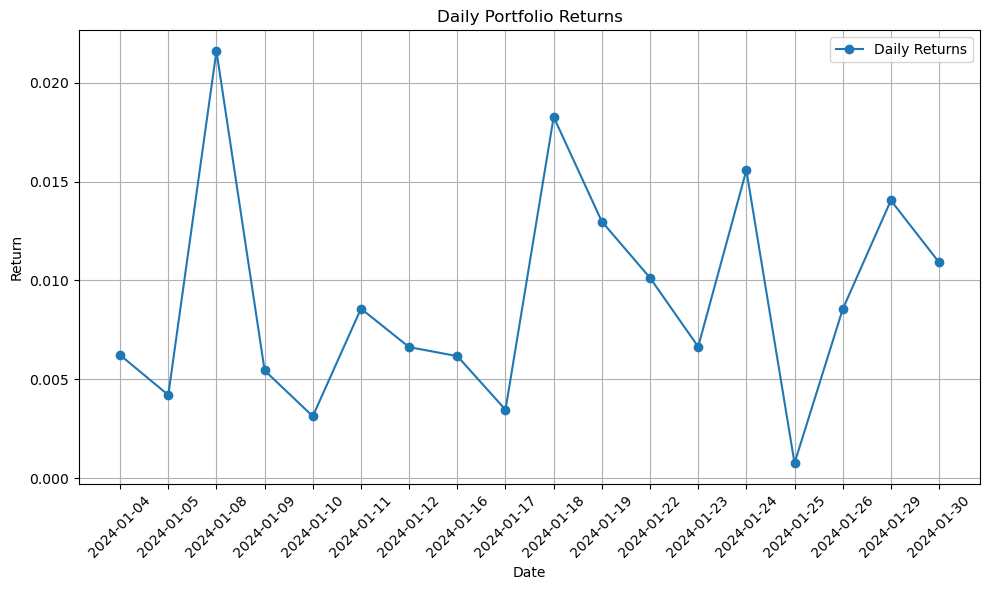

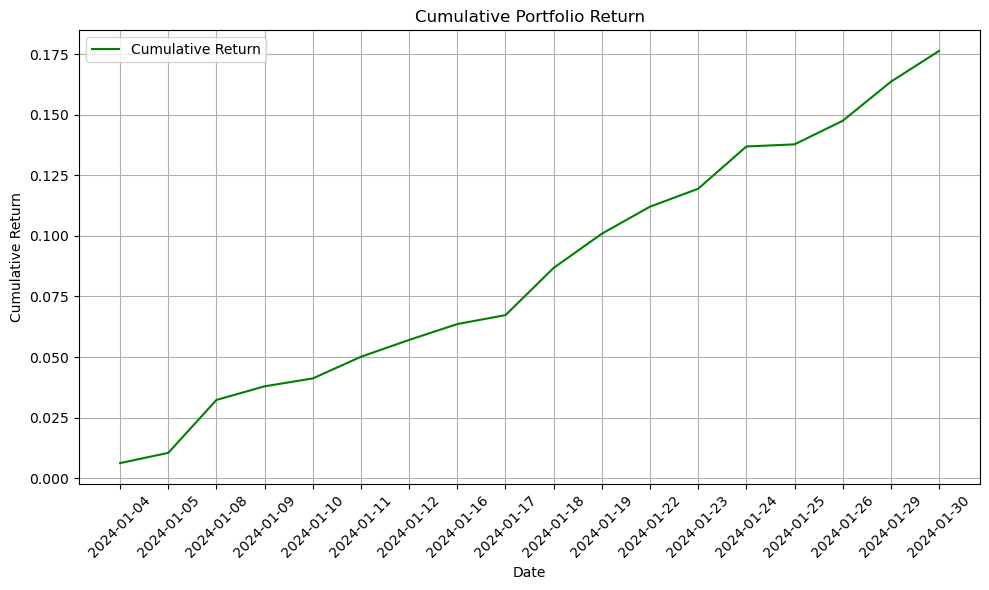

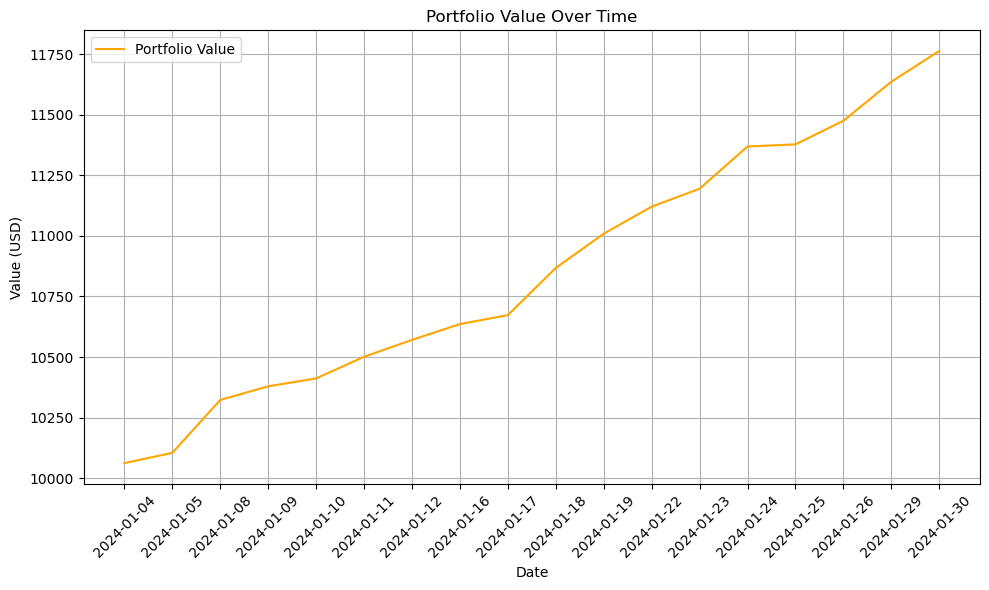

In [111]:
# Dados para o gráfico
portfolio_returns_df['Cumulative Return'] = (1 + portfolio_returns_df['Portfolio Return']).cumprod() - 1
portfolio_returns_df['Portfolio Value'] = initial_amount * ((1 + portfolio_returns_df['Portfolio Return']).cumprod())

# Gráfico 1: Retornos Diários
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['Date'], portfolio_returns_df['Portfolio Return'], marker='o', linestyle='-', label='Daily Returns')
plt.title('Daily Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 2: Retorno Acumulado
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['Date'], portfolio_returns_df['Cumulative Return'], color='green', label='Cumulative Return')
plt.title('Cumulative Portfolio Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 3: Valor do Portfólio
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['Date'], portfolio_returns_df['Portfolio Value'], color='orange', label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Em relação às `Daily Portfolio Returns` o gráfico confirma a variabilidade moderada nos retornos diários, com valores que variam entre 0% e 1,8%. Existem alguns picos positivos, como o observado em 2024-01-08 e 2024-01-18, que indicam dias de alto desempenho do portfólio. Os dias de retornos próximos de zero não impactaram negativamente o crescimento acumulado, pois não há valores negativos significativos. A estratégia conseguiu manter retornos positivos consistentes, com baixo risco de perdas diárias.

O segundo gráfico(`Cumulative Portfólio Return`) mostra um crescimento contínuo e estável do retorno acumulado, que atinge 17,5% no final do período. A linha verde apresenta uma inclinação constante, o que reflete uma performance robusta e resiliente ao longo do tempo. Pequenas oscilações observadas no gráfico de retornos diários não interrompem a tendência ascendente no retorno acumulado.  O portfólio real alcançou um equilíbrio eficiente entre risco e retorno, mantendo o crescimento de forma controlada.

Observando o gráfico `Portfolio Value Over Time` vemos que o valor do portfólio confirma o crescimento do saldo ao longo do período. A trajetória do portfólio apresenta um padrão de crescimento gradual e estável, sem quedas acentuadas. Pequenos patamares ou momentos de desaceleração refletem dias com retornos baixos, mas o crescimento continua em seguida. O portfólio foi resiliente e lucrativo, com ganhos acumulados consistentes ao longo do tempo.


Estes resultados destacam a eficiência e estabilidade da abordagem utilizada, sendo um excelente benchmark para comparação com os modelos (Random Forest e LSTM).

## Discussão de Resultados  <a name = "dr_cr"> </a>
[[voltar a Comparação de Resultados]](#cr)

Podemos por fim analisar os resultados finais:

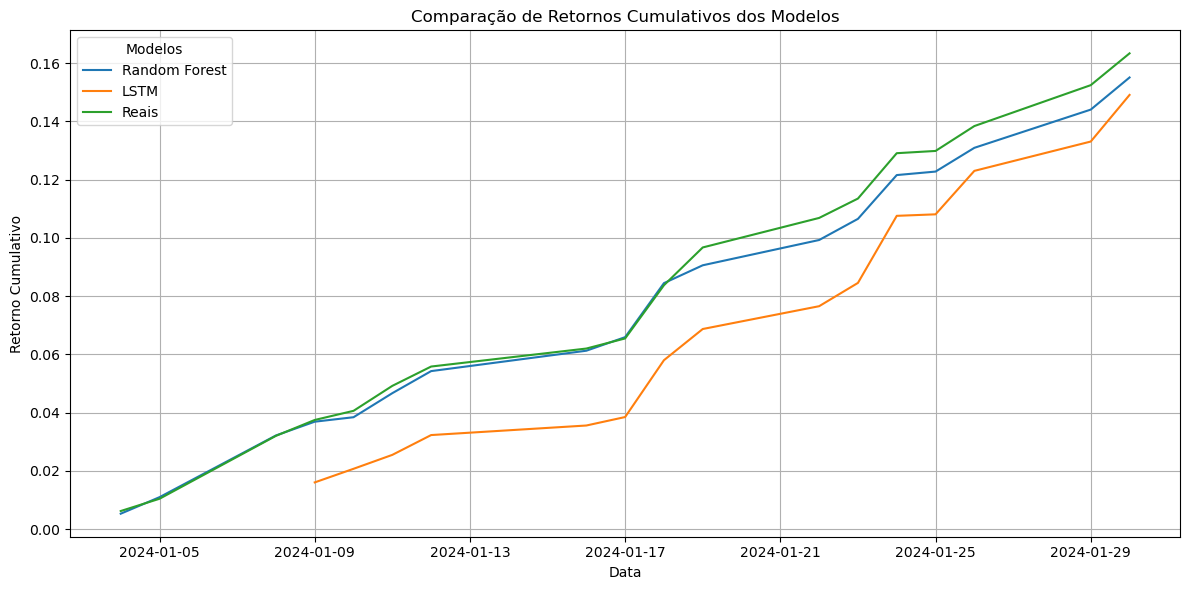

In [112]:
# Recarregar os arquivos diretamente do ambiente
file_rf = 'portfolio_returns_daily_rf.csv'
file_lstm = 'portfolio_returns_daily_lstm.csv'
file_reais = 'portfolio_returns_daily_reais.csv'

# Carregar os CSVs
model1 = pd.read_csv(file_rf)
model2 = pd.read_csv(file_lstm)
model3 = pd.read_csv(file_reais)

# Adicionar o nome dos modelos para o gráfico
model1['Model'] = 'Random Forest'
model2['Model'] = 'LSTM'
model3['Model'] = 'Reais'

# Combinar os dados em um único DataFrame
all_models = pd.concat([model1, model2, model3], ignore_index=True)

# Converter a coluna 'Date' para datetime
all_models['Date'] = pd.to_datetime(all_models['Date'])

# Criar uma coluna para o retorno acumulado de cada modelo
all_models['Cumulative Return'] = all_models.groupby('Model')['Portfolio Return'].cumsum()

# Plotar o gráfico comparativo
plt.figure(figsize=(12, 6))
for model in all_models['Model'].unique():
    model_data = all_models[all_models['Model'] == model]
    plt.plot(model_data['Date'], model_data['Cumulative Return'], label=model)

# Configurar o gráfico
plt.title('Comparação de Retornos Cumulativos dos Modelos')
plt.xlabel('Data')
plt.ylabel('Retorno Cumulativo')
plt.legend(title='Modelos')
plt.grid(True)
plt.tight_layout()

# Mostrar o gráfico
plt.show()


No início, os três retornos começam próximos, mas o LSTM começa a desviar-se logo nos primeiros dias, acumulando retornos significativamente menores.
Já o Random Forest mantém-se muito próximo dos retornos reais durante todo o período, mostrando maior capacidade de adaptação. No final do mês, o pior retorno é o do LSTM e o melhor é o dos dados reais.
O Random Forest parece ser o modelo mais eficaz para prever os retornos acumulativos, dada a sua proximidade com os retornos reais.
O LSTM, embora positivo, apresenta uma diferença mais significativa, indicando que talvez seja menos eficiente para este tipo de dado ou que precise de otimizações adicionais.



# Conclusão <a name = "conclusao"> </a>
[[voltar ao índice]](#indice)

O Random Forest é claramente o modelo mais confiável neste cenário, conseguindo replicar quase perfeitamente os retornos reais, mesmo com pequenas diferenças no final do mês.
O LSTM, apesar de ser um modelo sofisticado, não foi capaz de superar ou igualar o desempenho do Random Forest e dos retornos reais. Isso pode ser devido à necessidade de mais dados, melhor ajuste de hiperparâmetros, ou ao fato de que os dados históricos usados no treino não foram suficientes para capturar as complexidades do mercado.

Os algoritmos treinados e testados demonstram elevada aplicabilidade e impacto no contexto financeiro, pois oferece um abordagem robusta para a otimização e gestão de portfólios diários. Através da análise dos retornos reais e preditivos, é possível identificar estratégias que maximizam o retorno ajustado ao risco, métricas essenciais no setor financeiro.

O impacto da solução é considerável, pois fornece uma base quantitativa para a escolha e alocação de ativos, permitindo decisões informadas e inteligentes, procurando buscar o lucro. O retorno do modelo do Random Forest perto de 15% prova a eficiência da abordagem, oferencendo resultados lucrativos para investidores. 

O uso destes modelos devem levar considerações éticas e legais, as quais são analisadas no ficheiro à parte.

# Referências <a name = "ref"> </a>
[[voltar ao índice]](#indice)

[KAGGLE] <a name = "KAGGLE"></a> - https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?resource=download

[PSTK15] <a name = "PSTK15"></a> - Jigar Patel, Sahil Shah, Priyank Thakkar, and Ketan Kotecha. Predicting stock and stock price index movement using trend deterministic data preparation and machine learning techniques. Expert systems with applications, 42(1):259–268, 2015.

https://github.com/arogan178/lstm-stock-prediction-sp500/blob/master/LSTM-price-prediction-sp500.ipynb